In [2]:
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import shap
from sklearn import metrics
shap.initjs() # JavaScript plots
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import class_weight
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
import pickle
from sklearn.model_selection import train_test_split
# TUNING
from optuna.integration import OptunaSearchCV
from optuna import distributions as optdist
from sklearn.metrics import make_scorer
import optuna
# IMBLEARN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# METRICS
# Classification
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, classification_report
# Risk Prediction
from sklearn.metrics import brier_score_loss
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
colors =  nml.plots.colors.Colors
# SKLEARN
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, StratifiedGroupKFold
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
#Main
import pandas as pd
import numpy as np
from math import floor
import time
import pickle
from tqdm import tqdm
from collections import defaultdict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [106]:
PAT = "/Users/marinacamacho/Desktop/Master_I/Data_Final"
DIS = "Depression_4"
HEL = "No_Disease"
KME = "_6_"
MOD = "Multitask_4"
FET = "45X"

In [107]:
# Reading trainCohort_X1 from its file
with open(f"{PAT}/trainCohort_{DIS}{HEL}", "rb") as fp:
    data4_X = pickle.load(fp)

In [108]:
data4_Y = pd.read_csv(f'/Users/marinacamacho/Desktop/Master_I/CLUSTERING_PLOTS/data_clu{KME}.csv')
data4_Y = data4_Y.set_index('eid')

In [109]:
age4_Y = pd.read_csv(f'/Users/marinacamacho/Desktop/Master_I/Modelling/Alluvia_data4{HEL}.csv')
age4_Y = age4_Y.set_index('eid')

In [110]:
data4_X.shape, data4_Y.shape, age4_Y.shape

((117921, 237), (117921, 4), (117921, 12))

In [111]:
#data4_Y['Age'] = age4_Y['Age']

In [112]:
data4_X['Depression'] = (age4_Y['Age_at_Depression'] <= age4_Y['Age']).astype(int)
data4_X['CVD'] = (age4_Y['Age_at_CVD'] <= age4_Y['Age']).astype(int)
data4_X['Diabetes'] = (age4_Y['Age_at_Diabetes'] <= age4_Y['Age']).astype(int)

In [113]:
# Step 1: Remove constant columns
data4_X = data4_X.loc[:, data4_X.nunique() > 1]

# Step 2: Remove rows with more than 30% missing values
threshold_row = 0.7 * len(data4_X.columns)
data4_X = data4_X.dropna(thresh=threshold_row)

# Step 3: Remove columns with more than 30% missing values
threshold_col = 0.7 * len(data4_X)
data4_X = data4_X.dropna(axis=1, thresh=threshold_col)

In [114]:
clusters = pd.concat([data4_Y,data4_X],axis=1); clusters.head(2)

,Age_at_CVD,Age_at_Depression,Age_at_Diabetes,Cluster,Breastfed_baby,Adopted_child,Maternal_smoking_around_birth,Sex,Waist_circumference,Hip_circumference,...,High_blood_pressure_S,Chronic_bronchitis/emphysema_S,Breast_cancer_S,Bowel_cancer_S,Lung_cancer_S,Stroke_S,Heart_disease_S,Depression,CVD,Diabetes
eid,,,,,,,,,,,,,,,,,,,,,
1000028,53.128679,84.0,84.000000,0,1.0,0.0,0.0,1.0,120.0,113.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1000087,62.014374,84.0,62.014374,4,NaN,0.0,0.0,1.0,112.0,107.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [115]:
# Split the DataFrame into training and testing sets, with 70% of the data in the training set
train_df, test_df = train_test_split(clusters, test_size=0.3, random_state=27)

# Extract the target column and identifier column from the training and testing sets
train_X = train_df.drop(['Cluster', 'Age_at_CVD','Age_at_Depression','Age_at_Diabetes'], axis=1)
train_Y = train_df['Cluster']
train_feid = train_df.index

test_X = test_df.drop(['Cluster', 'Age_at_CVD','Age_at_Depression','Age_at_Diabetes'], axis=1)
test_Y = test_df['Cluster']
test_feid = test_df.index

In [116]:
train_X.shape, train_Y.shape, train_feid.shape

((82544, 169), (82544,), (82544,))

In [117]:
test_X.shape, test_Y.shape, test_feid.shape

((35377, 169), (35377,), (35377,))

In [118]:
trainData = train_X
y_train = train_Y
targets = pd.DataFrame(y_train)

In [119]:
testData = test_X
y_test = test_Y

In [120]:
class_weights = {k: train_X.shape[0] / count for k, count in pd.DataFrame(train_Y.value_counts()).items()}

In [121]:
class_weights

{'Cluster': 5     3.584039
 0     3.893401
 1     5.235902
 3     7.020242
 4    10.976596
 2    25.250535
 Name: Cluster, dtype: float64}

In [122]:
class_weights = {
    0: 3.893401,
    1: 5.235902,
    2: 6.999406,
    3: 7.020242,
    4: 10.976596,
    5: 25.250535
}

In [123]:
Normalize = False # Flag to determine whether to normalize data or not
OuterFolds = 5 # Number of outer cross-validation folds for model evaluation
InnerFolds = 3 # Number of inner cross-validation folds for hyperparameter tuning
random_state = 28 # Seed for random number generation to ensure reproducibility

In [124]:
from xgboost import XGBClassifier

# Initializing the XGBClassifier
XGB = XGBClassifier(random_state=random_state, use_label_encoder=False)

# Creating the XGBoost pipeline
XGB_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('RUS', RandomUnderSampler(random_state=random_state)),
    ('select_features', SelectFromModel(XGBClassifier(random_state=random_state, use_label_encoder=False), threshold='median', max_features=45)),
    ('XGB', XGB)
])

`use_label_encoder` is deprecated in 1.7.0.


In [126]:
# Parameter search space for XGBoost model
XGB_params = {
    #'RUS__sampling_strategy': optdist.FloatDistribution(low=0.3, high=0.7),
    #'SMOTE__k_neighbors': optdist.IntDistribution(low=3, high=7, step=2),
    'XGB__learning_rate': optdist.FloatDistribution(low=0.05, high=0.3),
    'XGB__min_child_weight': optdist.IntDistribution(low=1, high=5),
    'XGB__gamma': optdist.FloatDistribution(low=0.5, high=2),
    'XGB__subsample': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__colsample_bytree': optdist.FloatDistribution(low=0.6, high=1),
    'XGB__max_depth': optdist.IntDistribution(low=2, high=12)#,
    #'XGB__class_weight': optuna.distributions.CategoricalDistribution(['balanced', class_weights])}

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535} which is of type dict.


In [127]:
hyperparameters = {'XGB': XGB_params}

pipelines = {'XGB': XGB_pipeline}

In [128]:
def multiclass_roc_auc_score_ovr(y_true, y_pred, labels=None):
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
    
    auc_scores = [roc_auc_score(y_true_bin[:, i], y_pred[:, i]) for i in range(n_classes)]
    
    return np.mean(auc_scores)

inner_scoring = make_scorer(multiclass_roc_auc_score_ovr, needs_proba=True)


#inner_scoring = make_scorer(roc_auc_score, multi_class='ovo', average='macro', needs_proba=True)
skf = StratifiedKFold(n_splits=OuterFolds)

for i, (train_index, val_index) in enumerate(skf.split(trainData, targets)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={val_index}")
    
    fitted_models=dict()
    
    for name, pipeline in pipelines.items():
        print(f"Fitting {name}...")
        foldModels = {i: {
            'model': None,
            'threshold': 0.5
        } for i in range(OuterFolds)}
       
        Outer_start = time.perf_counter()

        for i in tqdm(range(OuterFolds)):
            # Pull training and validation splits for the outer fold 
            train_eids = list(pd.DataFrame(trainData.index).iloc[train_index]['eid'])
            val_eids = list(pd.DataFrame(trainData.index).iloc[val_index]['eid'])

            X_train = trainData.query('eid == @train_eids')
            X_val = trainData.query('eid == @val_eids')

            y_train = targets.query('eid == @train_eids')
            y_val = targets.query('eid == @val_eids')

            Inner_start = time.perf_counter()
            # Perform inner cross validation for hyper parameter tuning
            Inner_CV = OptunaSearchCV(
                estimator=pipeline,
                param_distributions=hyperparameters[name],
                cv=InnerFolds,
                error_score="raise",
                n_trials=10,
                scoring=inner_scoring,
                verbose=False,
                refit=True
            )

            Inner_CV.fit(X_train, y_train)

            best_model = Inner_CV.best_estimator_
            foldModels[i]['model'] = best_model

            #Evaluate optimal threshold on validation set
            #pred_thresh = thresholdSelector(best_model, X_val.values, y_val.values, f1_score)
            #foldModels[i]['threshold'] = pred_thresh
            foldModels[i]['features'] = foldModels[i]['model']['select_features'].get_support(indices=True)

            Inner_end = time.perf_counter()

        Outer_end = time.perf_counter()
        fitted_models[name] = foldModels
            
    with open(f"{PAT}/{MOD}/fitted_models_{DIS}{HEL}{FET}", "wb") as fp:
                pickle.dump(fitted_models, fp)

Fold 0:
  Train: index=[16276 16279 16283 ... 82541 82542 82543]
  Test:  index=[    0     1     2 ... 17354 17364 17370]
Fitting XGB...


  0%|                                                     | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 11:19:52,451] A new study created in memory with name: no-name-4f514af9-4740-4980-bdfe-ab282c521377
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:20:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:20:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:20:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:20:54,036] Trial 0 finished with value: 0.8501514876821151 and parameters: {'XGB__learning_rate': 0.2847207307898618, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.1386421774617306, 'XGB__subsample': 0.8269483097862517, 'XGB__colsample_bytree': 0.8571430008843477, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8501514876821151.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:21:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:21:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:21:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:21:50,864] Trial 1 finished with value: 0.8551957941544903 and parameters: {'XGB__learning_rate': 0.172106345894871, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.7762827537202186, 'XGB__subsample': 0.6210197846809437, 'XGB__colsample_bytree': 0.9708264298113771, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8551957941544903.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:22:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:22:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:22:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:22:46,398] Trial 2 finished with value: 0.8670247378479611 and parameters: {'XGB__learning_rate': 0.06620571590429393, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.99986018156538, 'XGB__subsample': 0.7147516279372547, 'XGB__colsample_bytree': 0.659214886870669, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670247378479611.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:22:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:23:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:23:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:23:34,406] Trial 3 finished with value: 0.8649465907630596 and parameters: {'XGB__learning_rate': 0.05019592861344409, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.7603612173024459, 'XGB__subsample': 0.8414661034405047, 'XGB__colsample_bytree': 0.9179437800825903, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8670247378479611.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:23:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:24:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:24:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:24:31,155] Trial 4 finished with value: 0.8591365014273054 and parameters: {'XGB__learning_rate': 0.22987100881114786, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.3741233255973442, 'XGB__subsample': 0.9524302334726521, 'XGB__colsample_bytree': 0.6032745254612674, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8670247378479611.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:24:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:25:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:25:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:25:33,695] Trial 5 finished with value: 0.8546413223510774 and parameters: {'XGB__learning_rate': 0.2655607556127276, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.8624785534459647, 'XGB__subsample': 0.6399597294735894, 'XGB__colsample_bytree': 0.7370149454468514, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670247378479611.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:25:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:26:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:26:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:26:37,606] Trial 6 finished with value: 0.8661755339380589 and parameters: {'XGB__learning_rate': 0.06813055884118195, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.7097396448403621, 'XGB__subsample': 0.905423253375633, 'XGB__colsample_bytree': 0.8908196819942047, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670247378479611.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:26:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:27:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:27:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:27:26,617] Trial 7 finished with value: 0.862679317177009 and parameters: {'XGB__learning_rate': 0.2969107804779589, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.0016687598235527, 'XGB__subsample': 0.6181640777653382, 'XGB__colsample_bytree': 0.792597935198918, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670247378479611.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:27:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:27:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:28:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:28:12,001] Trial 8 finished with value: 0.8711335861216294 and parameters: {'XGB__learning_rate': 0.23413787584894324, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.2270807729364996, 'XGB__subsample': 0.7925737510677288, 'XGB__colsample_bytree': 0.8156982881082155, 'XGB__max_depth': 2, 'XGB__class_weight': 'balanced'}. Best is trial 8 with value: 0.8711335861216294.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:28:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:28:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:29:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:29:19,376] Trial 9 finished with value: 0.8591713793954883 and parameters: {'XGB__learning_rate': 0.1467922122656951, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.330874848206654, 'XGB__subsample': 0.9842712390264001, 'XGB__colsample_bytree': 0.8130736643164411, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 8 with value: 0.8711335861216294.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:29:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 20%|████████▊                                   | 1/5 [09:48<39:13, 588.40s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 11:29:40,737] A new study created in memory with name: no-name-1fa19dee-f846-43fd-b9cf-b83acb134782
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:29:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:30:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:30:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:30:32,819] Trial 0 finished with value: 0.8694630536772646 and parameters: {'XGB__learning_rate': 0.17673203753542366, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.5486160953917512, 'XGB__subsample': 0.877065579498924, 'XGB__colsample_bytree': 0.9446238720286527, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:30:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:31:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:31:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:31:41,630] Trial 1 finished with value: 0.8560957108498054 and parameters: {'XGB__learning_rate': 0.24553581822836656, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.8830597532814608, 'XGB__subsample': 0.9084547482747128, 'XGB__colsample_bytree': 0.964131429980488, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:31:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:32:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:32:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:32:28,209] Trial 2 finished with value: 0.8687560183066472 and parameters: {'XGB__learning_rate': 0.07281495768979633, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.6128034611743657, 'XGB__subsample': 0.6738083693837842, 'XGB__colsample_bytree': 0.7220166475329747, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:32:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:33:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:33:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:33:36,113] Trial 3 finished with value: 0.8522791181114936 and parameters: {'XGB__learning_rate': 0.2910033636660843, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.576635063339904, 'XGB__subsample': 0.7483723759773886, 'XGB__colsample_bytree': 0.8955181542766346, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:33:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:34:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:34:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:34:34,830] Trial 4 finished with value: 0.8665796156735919 and parameters: {'XGB__learning_rate': 0.23258585946339572, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.7783097282811795, 'XGB__subsample': 0.9702217471778881, 'XGB__colsample_bytree': 0.8301279602914718, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:34:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:35:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:35:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:35:43,956] Trial 5 finished with value: 0.855408652283571 and parameters: {'XGB__learning_rate': 0.19672835277696216, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.9811599986208315, 'XGB__subsample': 0.7803551227994747, 'XGB__colsample_bytree': 0.8818127062183199, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:35:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:36:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:36:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:36:48,266] Trial 6 finished with value: 0.8680225348746964 and parameters: {'XGB__learning_rate': 0.07922353203090916, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.291004339186572, 'XGB__subsample': 0.829066382286951, 'XGB__colsample_bytree': 0.6330250912448082, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:37:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:37:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:37:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:38:01,428] Trial 7 finished with value: 0.8621851790298493 and parameters: {'XGB__learning_rate': 0.10661567233670742, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.8395110100035923, 'XGB__subsample': 0.9597912692066195, 'XGB__colsample_bytree': 0.6024702212620893, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:38:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:38:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:39:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:39:15,915] Trial 8 finished with value: 0.8571231477817801 and parameters: {'XGB__learning_rate': 0.26169483851676834, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.553557276851966, 'XGB__subsample': 0.9099999025593472, 'XGB__colsample_bytree': 0.9047135374670586, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:39:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:39:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:40:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:40:32,986] Trial 9 finished with value: 0.8643754690181615 and parameters: {'XGB__learning_rate': 0.09393895376897092, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.3691847704631677, 'XGB__subsample': 0.6298477879910267, 'XGB__colsample_bytree': 0.660579219352417, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8694630536772646.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:40:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 40%|█████████████████▌                          | 2/5 [21:10<32:10, 643.34s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 11:41:02,626] A new study created in memory with name: no-name-9c182dcf-ba2f-49dd-96ea-eb0ec0178881
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:41:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:41:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:42:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:42:10,260] Trial 0 finished with value: 0.8628169013872653 and parameters: {'XGB__learning_rate': 0.18603859261666778, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8016971286996128, 'XGB__subsample': 0.9206811453334962, 'XGB__colsample_bytree': 0.9841375555290055, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8628169013872653.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:42:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:42:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:43:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:43:14,414] Trial 1 finished with value: 0.864344633623507 and parameters: {'XGB__learning_rate': 0.2901793282109338, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.5459888208111194, 'XGB__subsample': 0.8198224879435289, 'XGB__colsample_bytree': 0.8418763359782246, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.864344633623507.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:43:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:43:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:44:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:44:31,586] Trial 2 finished with value: 0.8680547391141978 and parameters: {'XGB__learning_rate': 0.0552390146014423, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.779418287226955, 'XGB__subsample': 0.6762166790133982, 'XGB__colsample_bytree': 0.7512670813326738, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8680547391141978.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:44:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:45:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:45:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:45:35,833] Trial 3 finished with value: 0.868132553968208 and parameters: {'XGB__learning_rate': 0.29995213124293285, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.5761515833246948, 'XGB__subsample': 0.7784286107795336, 'XGB__colsample_bytree': 0.6215570521320379, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.868132553968208.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:45:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:46:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:46:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:46:33,259] Trial 4 finished with value: 0.8696652388853362 and parameters: {'XGB__learning_rate': 0.13860328623941665, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.472715737913388, 'XGB__subsample': 0.7607523080891322, 'XGB__colsample_bytree': 0.8604560930767906, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8696652388853362.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:46:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:47:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:47:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:47:57,630] Trial 5 finished with value: 0.8513027373781193 and parameters: {'XGB__learning_rate': 0.2839961438251245, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.0936339080047996, 'XGB__subsample': 0.7911903123315709, 'XGB__colsample_bytree': 0.6518894600627774, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 4 with value: 0.8696652388853362.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:48:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:48:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:49:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:49:11,911] Trial 6 finished with value: 0.8673090493708334 and parameters: {'XGB__learning_rate': 0.07578806458887223, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.2363799367475943, 'XGB__subsample': 0.989835397943496, 'XGB__colsample_bytree': 0.90066093205643, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8696652388853362.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:49:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:49:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:50:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:50:33,656] Trial 7 finished with value: 0.8565178095718076 and parameters: {'XGB__learning_rate': 0.1715658723896727, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.6068874162961819, 'XGB__subsample': 0.9873751669902628, 'XGB__colsample_bytree': 0.6517272561699372, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 4 with value: 0.8696652388853362.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:50:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:51:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:51:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:51:43,737] Trial 8 finished with value: 0.8648443839632841 and parameters: {'XGB__learning_rate': 0.27815070231651856, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.6842990028970208, 'XGB__subsample': 0.8989487170275055, 'XGB__colsample_bytree': 0.866779814804346, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8696652388853362.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:52:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:52:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:52:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:53:06,220] Trial 9 finished with value: 0.8515773119337412 and parameters: {'XGB__learning_rate': 0.24162226728596842, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.7722741062165189, 'XGB__subsample': 0.8273182090410963, 'XGB__colsample_bytree': 0.8975919650290192, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8696652388853362.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:53:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 60%|██████████████████████████▍                 | 3/5 [33:41<23:05, 692.60s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 11:53:33,867] A new study created in memory with name: no-name-a8e90914-8930-44a8-87b7-db8038d88b9e
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:53:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:54:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:54:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:54:55,651] Trial 0 finished with value: 0.8664840558438537 and parameters: {'XGB__learning_rate': 0.0922401264117788, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.9183261014580661, 'XGB__subsample': 0.821156097060414, 'XGB__colsample_bytree': 0.8717043779921075, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8664840558438537.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:55:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:55:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:56:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:56:20,078] Trial 1 finished with value: 0.8620375417845434 and parameters: {'XGB__learning_rate': 0.11010888522358205, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.1798898740081127, 'XGB__subsample': 0.8546904102336155, 'XGB__colsample_bytree': 0.8315793785061891, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8664840558438537.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:56:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:56:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:57:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:57:18,780] Trial 2 finished with value: 0.8703643704737359 and parameters: {'XGB__learning_rate': 0.1965788670110305, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.9889035905402317, 'XGB__subsample': 0.9423264559891116, 'XGB__colsample_bytree': 0.6928527829445984, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8703643704737359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:57:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:58:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:58:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:58:44,228] Trial 3 finished with value: 0.8505272332899221 and parameters: {'XGB__learning_rate': 0.29648397591084813, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.8592913169448575, 'XGB__subsample': 0.6551102148806071, 'XGB__colsample_bytree': 0.836813958237488, 'XGB__max_depth': 7, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8703643704737359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:59:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:59:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[11:59:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 11:59:50,360] Trial 4 finished with value: 0.8655795111658638 and parameters: {'XGB__learning_rate': 0.10510145199411648, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.8177059688689459, 'XGB__subsample': 0.7020322060046337, 'XGB__colsample_bytree': 0.6836107132869671, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8703643704737359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:00:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:00:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:00:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:00:42,647] Trial 5 finished with value: 0.8711075984221189 and parameters: {'XGB__learning_rate': 0.23727390554428235, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.8800737857790664, 'XGB__subsample': 0.8389370162338801, 'XGB__colsample_bytree': 0.7554506066520726, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8711075984221189.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:01:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:01:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:02:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:02:12,944] Trial 6 finished with value: 0.8579288801771074 and parameters: {'XGB__learning_rate': 0.16029487506403334, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.405664389702903, 'XGB__subsample': 0.6627661910678725, 'XGB__colsample_bytree': 0.6578903774425557, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8711075984221189.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:02:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:02:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:03:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:03:30,892] Trial 7 finished with value: 0.8604905694237268 and parameters: {'XGB__learning_rate': 0.12755309543380794, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.0357489140627307, 'XGB__subsample': 0.8155271644599164, 'XGB__colsample_bytree': 0.7414340670884229, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8711075984221189.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:03:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:04:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:05:07,262] Trial 8 finished with value: 0.8550824606248867 and parameters: {'XGB__learning_rate': 0.24153470429890123, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.9059178687194145, 'XGB__subsample': 0.979551261678355, 'XGB__colsample_bytree': 0.6655714603773049, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 5 with value: 0.8711075984221189.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:05:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:05:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:06:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:06:51,356] Trial 9 finished with value: 0.850455735276065 and parameters: {'XGB__learning_rate': 0.25622648784906765, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.5849456481572531, 'XGB__subsample': 0.9172844999028448, 'XGB__colsample_bytree': 0.7738304442779333, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8711075984221189.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:07:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 80%|███████████████████████████████████▏        | 4/5 [47:34<12:28, 748.22s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 12:07:27,541] A new study created in memory with name: no-name-20f355d8-7854-4907-b1e7-2c60c586a046
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:07:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:08:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:08:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:08:45,915] Trial 0 finished with value: 0.8707293057373359 and parameters: {'XGB__learning_rate': 0.1252752169851446, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.8130778301549546, 'XGB__subsample': 0.9097638749688934, 'XGB__colsample_bytree': 0.8483041447660695, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:09:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:09:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:10:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:10:35,131] Trial 1 finished with value: 0.8595804057127979 and parameters: {'XGB__learning_rate': 0.16885273288092983, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.6001685603728393, 'XGB__subsample': 0.8326317676649952, 'XGB__colsample_bytree': 0.6664945897837101, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:11:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:11:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:12:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:12:22,612] Trial 2 finished with value: 0.8664346144120936 and parameters: {'XGB__learning_rate': 0.11614332991969768, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.7780885476265615, 'XGB__subsample': 0.6855526354561972, 'XGB__colsample_bytree': 0.7695137590914621, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:12:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:13:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:13:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:14:09,736] Trial 3 finished with value: 0.846053504555619 and parameters: {'XGB__learning_rate': 0.29453828742486143, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.802242570858496, 'XGB__subsample': 0.6099230556603127, 'XGB__colsample_bytree': 0.7396727676364846, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:14:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:14:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:15:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:15:34,038] Trial 4 finished with value: 0.8655402137112529 and parameters: {'XGB__learning_rate': 0.217584664078881, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.965556006284238, 'XGB__subsample': 0.7727553341318291, 'XGB__colsample_bytree': 0.6037363877466481, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:15:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:16:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:17:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:17:23,820] Trial 5 finished with value: 0.852580864595939 and parameters: {'XGB__learning_rate': 0.18336873275896465, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.7095888705445846, 'XGB__subsample': 0.8394840471296733, 'XGB__colsample_bytree': 0.7134786876473349, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:17:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:18:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:18:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:18:53,924] Trial 6 finished with value: 0.8559202046347324 and parameters: {'XGB__learning_rate': 0.1896422291383013, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.7391133493912244, 'XGB__subsample': 0.6065243497421215, 'XGB__colsample_bytree': 0.8393031858096995, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:19:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:19:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:20:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:20:15,359] Trial 7 finished with value: 0.8643412764329446 and parameters: {'XGB__learning_rate': 0.22166012351161202, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.8000080178490505, 'XGB__subsample': 0.8149172159713856, 'XGB__colsample_bytree': 0.6568743502613125, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8707293057373359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:20:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:21:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:21:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:21:34,501] Trial 8 finished with value: 0.8709540007562216 and parameters: {'XGB__learning_rate': 0.2709050514769527, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.017043264141948, 'XGB__subsample': 0.9786976339711245, 'XGB__colsample_bytree': 0.9813918102682555, 'XGB__max_depth': 2, 'XGB__class_weight': 'balanced'}. Best is trial 8 with value: 0.8709540007562216.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:21:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:22:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:23:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:23:17,680] Trial 9 finished with value: 0.8501119935904935 and parameters: {'XGB__learning_rate': 0.2810747053969192, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.6300894349230748, 'XGB__subsample': 0.9591615201326017, 'XGB__colsample_bytree': 0.6083343655646893, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 8 with value: 0.8709540007562216.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:23:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



100%|██████████████████████████████████████████| 5/5 [1:04:01<00:00, 768.29s/it]


Fold 1:
  Train: index=[    0     1     2 ... 82541 82542 82543]
  Test:  index=[16276 16279 16283 ... 33529 33536 33537]
Fitting XGB...


  0%|                                                     | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 12:23:54,269] A new study created in memory with name: no-name-247d7c13-8458-47db-a015-12845924f863
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:24:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:24:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:25:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:25:35,906] Trial 0 finished with value: 0.8594125275644942 and parameters: {'XGB__learning_rate': 0.15331271319250145, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.3508291400609005, 'XGB__subsample': 0.6795375450329879, 'XGB__colsample_bytree': 0.9313740641883136, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8594125275644942.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:25:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:26:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:27:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:27:18,671] Trial 1 finished with value: 0.8549155684158588 and parameters: {'XGB__learning_rate': 0.1756043148095911, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.5599370719579055, 'XGB__subsample': 0.7762068795705963, 'XGB__colsample_bytree': 0.967484753132808, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8594125275644942.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:27:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:28:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:28:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:28:32,971] Trial 2 finished with value: 0.8645004625115388 and parameters: {'XGB__learning_rate': 0.08007324065812944, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.2382708979386488, 'XGB__subsample': 0.966902531172964, 'XGB__colsample_bytree': 0.7297712977787745, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8645004625115388.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:28:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:29:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:30:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:30:22,668] Trial 3 finished with value: 0.8464064425458316 and parameters: {'XGB__learning_rate': 0.2985079399697558, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.95765163326194, 'XGB__subsample': 0.6311740280510132, 'XGB__colsample_bytree': 0.6109604343791666, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8645004625115388.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:30:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:31:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:31:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:31:51,143] Trial 4 finished with value: 0.8668455502846962 and parameters: {'XGB__learning_rate': 0.14386912261467377, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.5180127981907803, 'XGB__subsample': 0.8735956652590974, 'XGB__colsample_bytree': 0.7778937909773086, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8668455502846962.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:32:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:33:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:33:37,983] Trial 5 finished with value: 0.8568917449000542 and parameters: {'XGB__learning_rate': 0.18101811910895377, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.9928956838056547, 'XGB__subsample': 0.7809156711278646, 'XGB__colsample_bytree': 0.604469372220305, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8668455502846962.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:33:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:34:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:35:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:35:17,849] Trial 6 finished with value: 0.8548832133957829 and parameters: {'XGB__learning_rate': 0.25007740597668326, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.2023958674923616, 'XGB__subsample': 0.8170752775451171, 'XGB__colsample_bytree': 0.8947352513483711, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8668455502846962.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:35:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:36:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:36:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:36:50,866] Trial 7 finished with value: 0.8555398539682645 and parameters: {'XGB__learning_rate': 0.2640725964762802, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.676416445387334, 'XGB__subsample': 0.6057507174741954, 'XGB__colsample_bytree': 0.6638400957495557, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 4 with value: 0.8668455502846962.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:37:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:37:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:38:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:38:14,097] Trial 8 finished with value: 0.870156667952329 and parameters: {'XGB__learning_rate': 0.2090776574444751, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.670878699211209, 'XGB__subsample': 0.9447866327992441, 'XGB__colsample_bytree': 0.8033701440140218, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 8 with value: 0.870156667952329.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:38:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:39:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:39:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:40:08,568] Trial 9 finished with value: 0.8671984850915991 and parameters: {'XGB__learning_rate': 0.058057451694406806, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.4355433539022262, 'XGB__subsample': 0.8723880814218024, 'XGB__colsample_bytree': 0.7543715763155927, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 8 with value: 0.870156667952329.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:40:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 20%|████████▏                                | 1/5 [16:55<1:07:41, 1015.30s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 12:40:49,544] A new study created in memory with name: no-name-57ba27d3-f419-414b-98ca-fd2e65a625fa
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:41:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:41:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:42:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:42:58,164] Trial 0 finished with value: 0.8597012546827503 and parameters: {'XGB__learning_rate': 0.11727410083269492, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.163727032150338, 'XGB__subsample': 0.9426297651155049, 'XGB__colsample_bytree': 0.8546751429259873, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8597012546827503.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:43:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:43:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:44:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:44:28,758] Trial 1 finished with value: 0.8694376836520973 and parameters: {'XGB__learning_rate': 0.13774359261270241, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8568868648473318, 'XGB__subsample': 0.8801209658201598, 'XGB__colsample_bytree': 0.6667634442108431, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8694376836520973.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:44:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:45:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:46:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:46:19,220] Trial 2 finished with value: 0.8620086326372244 and parameters: {'XGB__learning_rate': 0.22865581382992634, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.95850325608049, 'XGB__subsample': 0.8981325583082841, 'XGB__colsample_bytree': 0.9389462582488215, 'XGB__max_depth': 7, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8694376836520973.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:46:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:47:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:48:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:48:34,165] Trial 3 finished with value: 0.8497983540417927 and parameters: {'XGB__learning_rate': 0.2478499384546735, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.8157587446211279, 'XGB__subsample': 0.747178685496458, 'XGB__colsample_bytree': 0.9075803568920116, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8694376836520973.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:49:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:49:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:50:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:50:29,917] Trial 4 finished with value: 0.8621869912421171 and parameters: {'XGB__learning_rate': 0.17555907167460222, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.694521313915785, 'XGB__subsample': 0.6720992128686457, 'XGB__colsample_bytree': 0.698939505958836, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8694376836520973.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:50:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:51:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:52:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:52:44,836] Trial 5 finished with value: 0.8596386043215921 and parameters: {'XGB__learning_rate': 0.13055485396228284, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.246893699444789, 'XGB__subsample': 0.795532523264757, 'XGB__colsample_bytree': 0.9790192576976184, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8694376836520973.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:53:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:53:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:54:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:54:26,820] Trial 6 finished with value: 0.8701806182652692 and parameters: {'XGB__learning_rate': 0.06457992678153184, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.8291028602038175, 'XGB__subsample': 0.7908377969327071, 'XGB__colsample_bytree': 0.7983950332080499, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 6 with value: 0.8701806182652692.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:54:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:55:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:56:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:56:09,094] Trial 7 finished with value: 0.8707774690740407 and parameters: {'XGB__learning_rate': 0.1959064660497034, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.552835580567121, 'XGB__subsample': 0.876632012421561, 'XGB__colsample_bytree': 0.7563817794999597, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8707774690740407.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:56:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:57:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:57:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:57:57,883] Trial 8 finished with value: 0.8460263342390938 and parameters: {'XGB__learning_rate': 0.2924724777835034, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.7276237069262932, 'XGB__subsample': 0.6239968612931664, 'XGB__colsample_bytree': 0.7098993060450616, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8707774690740407.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:58:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:59:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[12:59:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 12:59:54,578] Trial 9 finished with value: 0.8604093947059622 and parameters: {'XGB__learning_rate': 0.11303424963471316, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.1431452843658396, 'XGB__subsample': 0.779488962360066, 'XGB__colsample_bytree': 0.8882247926570292, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8707774690740407.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:00:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 40%|█████████████████▏                         | 2/5 [36:39<55:43, 1114.60s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 13:00:33,609] A new study created in memory with name: no-name-d405d166-e625-4a09-984f-22dfda8ee4b2
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:00:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:01:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:02:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:02:23,576] Trial 0 finished with value: 0.8586348040773503 and parameters: {'XGB__learning_rate': 0.15141449310619548, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.0006224018102656, 'XGB__subsample': 0.8339292804864453, 'XGB__colsample_bytree': 0.7716837814518209, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8586348040773503.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:02:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:03:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:03:41,588] Trial 1 finished with value: 0.8708105884488138 and parameters: {'XGB__learning_rate': 0.24743352803578955, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.6853566677469813, 'XGB__subsample': 0.7107954997220005, 'XGB__colsample_bytree': 0.9465066172377418, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:04:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:04:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:05:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:05:14,289] Trial 2 finished with value: 0.8611379759562947 and parameters: {'XGB__learning_rate': 0.19666105172070358, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.5680978488519757, 'XGB__subsample': 0.6761928865251198, 'XGB__colsample_bytree': 0.7469048158809055, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:05:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:06:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:06:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:07:05,868] Trial 3 finished with value: 0.85859497822715 and parameters: {'XGB__learning_rate': 0.1445660710504642, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.0553579504961024, 'XGB__subsample': 0.8052144731555753, 'XGB__colsample_bytree': 0.8979128285191742, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:07:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:07:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:08:23,402] Trial 4 finished with value: 0.8696799877623498 and parameters: {'XGB__learning_rate': 0.07831057931619297, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.220358751689029, 'XGB__subsample': 0.617630482260311, 'XGB__colsample_bytree': 0.6327536960116612, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:08:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:09:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:09:48,874] Trial 5 finished with value: 0.858969286629783 and parameters: {'XGB__learning_rate': 0.17869669784749087, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.4644347191090983, 'XGB__subsample': 0.6618826532205532, 'XGB__colsample_bytree': 0.8448099761089527, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:10:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:10:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:11:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:11:10,815] Trial 6 finished with value: 0.8628057511002978 and parameters: {'XGB__learning_rate': 0.1412195384290248, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.3239579114627236, 'XGB__subsample': 0.9661719397575861, 'XGB__colsample_bytree': 0.915814582037801, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:11:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:11:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:12:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:12:22,696] Trial 7 finished with value: 0.8682614361342172 and parameters: {'XGB__learning_rate': 0.13843124079329383, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.4680139186950387, 'XGB__subsample': 0.8366693922874757, 'XGB__colsample_bytree': 0.8637165169462249, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8708105884488138.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:12:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:13:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:13:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:13:27,800] Trial 8 finished with value: 0.8709931770133519 and parameters: {'XGB__learning_rate': 0.16264715169448613, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.7887322632770026, 'XGB__subsample': 0.8232274060210318, 'XGB__colsample_bytree': 0.965168254979628, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 8 with value: 0.8709931770133519.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:13:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:14:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:14:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:14:51,170] Trial 9 finished with value: 0.8656423655909801 and parameters: {'XGB__learning_rate': 0.08360826995299549, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.546184188524917, 'XGB__subsample': 0.9968529019759593, 'XGB__colsample_bytree': 0.7649370622403243, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 8 with value: 0.8709931770133519.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:15:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 60%|█████████████████████████▊                 | 3/5 [51:28<33:42, 1011.47s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 13:15:22,285] A new study created in memory with name: no-name-ecf00217-dedb-41ff-b405-0bb1cc9d5c6c
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:15:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:16:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:16:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:16:38,941] Trial 0 finished with value: 0.8610383964451689 and parameters: {'XGB__learning_rate': 0.15596325452768678, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8670271121450022, 'XGB__subsample': 0.759404153386071, 'XGB__colsample_bytree': 0.668985150482208, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8610383964451689.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:16:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:17:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:17:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:18:00,904] Trial 1 finished with value: 0.8624505288433729 and parameters: {'XGB__learning_rate': 0.21540697578147283, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.4065424523421064, 'XGB__subsample': 0.7221017259891986, 'XGB__colsample_bytree': 0.7234256856700515, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8624505288433729.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:18:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:18:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:19:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:19:13,081] Trial 2 finished with value: 0.8709892328385318 and parameters: {'XGB__learning_rate': 0.20124357414307842, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.8213457395719614, 'XGB__subsample': 0.8085906460430456, 'XGB__colsample_bytree': 0.967647963855292, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:19:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:19:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:20:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:20:24,734] Trial 3 finished with value: 0.8683321232395493 and parameters: {'XGB__learning_rate': 0.29142699456372073, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.9357122262104797, 'XGB__subsample': 0.8153714897495546, 'XGB__colsample_bytree': 0.719927954177101, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:20:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:21:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:21:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:21:45,112] Trial 4 finished with value: 0.8559652871796773 and parameters: {'XGB__learning_rate': 0.22346844921177011, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.078732192383785, 'XGB__subsample': 0.7347786992356973, 'XGB__colsample_bytree': 0.9305690390578737, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:22:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:22:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:23:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:23:17,944] Trial 5 finished with value: 0.861425188292266 and parameters: {'XGB__learning_rate': 0.08880843017579686, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.912340645151567, 'XGB__subsample': 0.7298050129872845, 'XGB__colsample_bytree': 0.9426898901505096, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:23:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:24:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:24:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:24:44,318] Trial 6 finished with value: 0.8531494791583373 and parameters: {'XGB__learning_rate': 0.29204935955540895, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.461084173307044, 'XGB__subsample': 0.9244675668120388, 'XGB__colsample_bytree': 0.836080857874187, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:25:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:25:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:25:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:25:55,207] Trial 7 finished with value: 0.8651076508396948 and parameters: {'XGB__learning_rate': 0.23872919996836106, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.5113332835822835, 'XGB__subsample': 0.6877644921472831, 'XGB__colsample_bytree': 0.9529561219193841, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:26:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:26:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:27:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:27:04,595] Trial 8 finished with value: 0.8707930677558583 and parameters: {'XGB__learning_rate': 0.14938847024636237, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.1725739877819934, 'XGB__subsample': 0.9693646956770667, 'XGB__colsample_bytree': 0.856938654551761, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:27:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:27:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:28:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:28:13,927] Trial 9 finished with value: 0.8708685397421346 and parameters: {'XGB__learning_rate': 0.17789216609534703, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.5539091795631652, 'XGB__subsample': 0.9367812784560238, 'XGB__colsample_bytree': 0.8684062598251618, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8709892328385318.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:28:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 80%|█████████████████████████████████▌        | 4/5 [1:04:51<15:29, 929.34s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 13:28:45,772] A new study created in memory with name: no-name-bd2f313b-0f38-4e9e-b550-7c21f3992667
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:29:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:29:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:29:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:29:55,906] Trial 0 finished with value: 0.8698316182406849 and parameters: {'XGB__learning_rate': 0.2548224540830503, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.9334597603474286, 'XGB__subsample': 0.8298372125683173, 'XGB__colsample_bytree': 0.9824796685337706, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8698316182406849.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:30:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:30:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:30:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:30:56,357] Trial 1 finished with value: 0.8705107192142792 and parameters: {'XGB__learning_rate': 0.18243200595809644, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.7659540472539095, 'XGB__subsample': 0.9926383645086229, 'XGB__colsample_bytree': 0.7293631170593162, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8705107192142792.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:31:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:31:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:32:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:32:26,882] Trial 2 finished with value: 0.866629585721399 and parameters: {'XGB__learning_rate': 0.06628154457170464, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.871350648268277, 'XGB__subsample': 0.9871999936286947, 'XGB__colsample_bytree': 0.9183496169403154, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8705107192142792.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:32:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:33:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:33:35,077] Trial 3 finished with value: 0.8706991363260435 and parameters: {'XGB__learning_rate': 0.2605196758590937, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.8375736587234968, 'XGB__subsample': 0.7811906160497062, 'XGB__colsample_bytree': 0.8711613382388378, 'XGB__max_depth': 2, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:33:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:34:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:35:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:35:14,407] Trial 4 finished with value: 0.8601807977649711 and parameters: {'XGB__learning_rate': 0.16316974095772208, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.5612842126530238, 'XGB__subsample': 0.7509608658869599, 'XGB__colsample_bytree': 0.6072834264106621, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:35:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:36:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:36:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:36:33,518] Trial 5 finished with value: 0.8643780047862489 and parameters: {'XGB__learning_rate': 0.19269055763431803, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.9215223687180922, 'XGB__subsample': 0.7108647974012278, 'XGB__colsample_bytree': 0.9870177341703581, 'XGB__max_depth': 5, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:36:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:37:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:37:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:38:02,268] Trial 6 finished with value: 0.8637204889658067 and parameters: {'XGB__learning_rate': 0.15026374482245985, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.9473736534681614, 'XGB__subsample': 0.6641263780455507, 'XGB__colsample_bytree': 0.8498885577746916, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:38:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:38:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:39:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:39:22,260] Trial 7 finished with value: 0.8693354622358623 and parameters: {'XGB__learning_rate': 0.09073382430515191, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.571439991573817, 'XGB__subsample': 0.627353236572187, 'XGB__colsample_bytree': 0.6894384939302933, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:39:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:40:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:40:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:40:50,920] Trial 8 finished with value: 0.8586024380720247 and parameters: {'XGB__learning_rate': 0.14978557874151177, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.0706908046948378, 'XGB__subsample': 0.8536367880643507, 'XGB__colsample_bytree': 0.8449529379502325, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:41:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:41:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:41:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:42:04,041] Trial 9 finished with value: 0.865759039535782 and parameters: {'XGB__learning_rate': 0.08947128511930429, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.6459037886015928, 'XGB__subsample': 0.6677698576112305, 'XGB__colsample_bytree': 0.8310806692932591, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8706991363260435.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:42:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



100%|██████████████████████████████████████████| 5/5 [1:18:38<00:00, 943.75s/it]


Fold 2:
  Train: index=[    0     1     2 ... 82541 82542 82543]
  Test:  index=[32661 32664 32666 ... 49787 49822 49829]
Fitting XGB...


  0%|                                                     | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 13:42:33,053] A new study created in memory with name: no-name-8da94844-e658-415c-a6ba-360c6aa6d8d5
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:42:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:43:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:43:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:44:08,305] Trial 0 finished with value: 0.8590186494388715 and parameters: {'XGB__learning_rate': 0.08580419299581545, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.5213489300105965, 'XGB__subsample': 0.7806517856088386, 'XGB__colsample_bytree': 0.9248320966051163, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8590186494388715.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:44:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:44:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:45:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:45:25,151] Trial 1 finished with value: 0.8653473678325173 and parameters: {'XGB__learning_rate': 0.10961545876493477, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.6274873006108272, 'XGB__subsample': 0.9798227463052933, 'XGB__colsample_bytree': 0.6173407949414655, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8653473678325173.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:45:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:46:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:46:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:46:47,258] Trial 2 finished with value: 0.8541580286851317 and parameters: {'XGB__learning_rate': 0.21252234904846784, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.4326143309880512, 'XGB__subsample': 0.7194106197619524, 'XGB__colsample_bytree': 0.6640867312754094, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8653473678325173.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:47:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:47:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:47:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:47:58,640] Trial 3 finished with value: 0.8701866844209182 and parameters: {'XGB__learning_rate': 0.1127324611185636, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.145088853978975, 'XGB__subsample': 0.6334100361032751, 'XGB__colsample_bytree': 0.8834286168432639, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:48:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:48:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:48:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:49:00,168] Trial 4 finished with value: 0.8701834259669124 and parameters: {'XGB__learning_rate': 0.23114432132808477, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.1835129137887792, 'XGB__subsample': 0.7638284197575778, 'XGB__colsample_bytree': 0.8510299424646381, 'XGB__max_depth': 2, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:49:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:49:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:50:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:50:22,692] Trial 5 finished with value: 0.8528852036605558 and parameters: {'XGB__learning_rate': 0.2206096048088118, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.7637880271370149, 'XGB__subsample': 0.9220780720637041, 'XGB__colsample_bytree': 0.7492058781960811, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:50:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:51:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:51:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:51:34,417] Trial 6 finished with value: 0.8558994375471561 and parameters: {'XGB__learning_rate': 0.24303826795514638, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.5076399270419003, 'XGB__subsample': 0.7385574425072741, 'XGB__colsample_bytree': 0.9261638801149077, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:51:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:52:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:52:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:53:01,543] Trial 7 finished with value: 0.857300845661667 and parameters: {'XGB__learning_rate': 0.13642238216566654, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.9517030529680279, 'XGB__subsample': 0.9915589563913001, 'XGB__colsample_bytree': 0.866103709705927, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:53:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:53:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:54:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:54:23,807] Trial 8 finished with value: 0.8546175862033012 and parameters: {'XGB__learning_rate': 0.2010143826876873, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.5894845768148822, 'XGB__subsample': 0.6106326569729043, 'XGB__colsample_bytree': 0.8394720148641663, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:54:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:55:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:55:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:55:24,881] Trial 9 finished with value: 0.8680965108727471 and parameters: {'XGB__learning_rate': 0.284478642004211, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.5446279844337076, 'XGB__subsample': 0.8847180778244211, 'XGB__colsample_bytree': 0.6555801276163984, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8701866844209182.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:55:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 20%|████████▊                                   | 1/5 [13:23<53:33, 803.29s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 13:55:56,382] A new study created in memory with name: no-name-66d0070c-1d46-4761-94b5-fb89cc416acb
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:56:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:56:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:57:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:57:24,057] Trial 0 finished with value: 0.8526932823584571 and parameters: {'XGB__learning_rate': 0.26178626209638295, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.8611493871151534, 'XGB__subsample': 0.6666553242524916, 'XGB__colsample_bytree': 0.7453093461753358, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8526932823584571.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:57:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:58:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:58:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:58:31,405] Trial 1 finished with value: 0.8685121138978026 and parameters: {'XGB__learning_rate': 0.057539119105934525, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.5808832438121594, 'XGB__subsample': 0.8543390654871419, 'XGB__colsample_bytree': 0.7036820690369702, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8685121138978026.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:58:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:59:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:59:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 13:59:37,598] Trial 2 finished with value: 0.866650180898546 and parameters: {'XGB__learning_rate': 0.2689497455383524, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.8442154618820288, 'XGB__subsample': 0.8598264831976694, 'XGB__colsample_bytree': 0.7739942783059974, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8685121138978026.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[13:59:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:00:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:00:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:00:47,310] Trial 3 finished with value: 0.8623024067417134 and parameters: {'XGB__learning_rate': 0.2641972466840548, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.9314884849692295, 'XGB__subsample': 0.7700676906517161, 'XGB__colsample_bytree': 0.9610353091311883, 'XGB__max_depth': 5, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8685121138978026.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:01:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:01:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:01:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:02:02,539] Trial 4 finished with value: 0.8663412029426786 and parameters: {'XGB__learning_rate': 0.11319712515335385, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.7165063088671184, 'XGB__subsample': 0.9656999049311864, 'XGB__colsample_bytree': 0.649570136029294, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8685121138978026.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:02:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:02:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:03:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:03:19,557] Trial 5 finished with value: 0.8615285345079924 and parameters: {'XGB__learning_rate': 0.12250851933059555, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.6617501885863195, 'XGB__subsample': 0.8044198601200431, 'XGB__colsample_bytree': 0.7675449658859829, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8685121138978026.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:03:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:03:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:04:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:04:19,378] Trial 6 finished with value: 0.8699010339252391 and parameters: {'XGB__learning_rate': 0.17994708123470876, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.5153545621883011, 'XGB__subsample': 0.8228504713961001, 'XGB__colsample_bytree': 0.6733752848945715, 'XGB__max_depth': 2, 'XGB__class_weight': 'balanced'}. Best is trial 6 with value: 0.8699010339252391.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:04:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:04:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:05:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:05:24,509] Trial 7 finished with value: 0.8695383591470159 and parameters: {'XGB__learning_rate': 0.13979713308504688, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.513204087503256, 'XGB__subsample': 0.8146036472697157, 'XGB__colsample_bytree': 0.6757004099220184, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 6 with value: 0.8699010339252391.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:05:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:06:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:06:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:06:41,248] Trial 8 finished with value: 0.8549216371067877 and parameters: {'XGB__learning_rate': 0.28937883658855146, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.6589377434800507, 'XGB__subsample': 0.7083943448067584, 'XGB__colsample_bytree': 0.6180616113815514, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 6 with value: 0.8699010339252391.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:07:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:07:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:07:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:08:01,441] Trial 9 finished with value: 0.8649067050744308 and parameters: {'XGB__learning_rate': 0.16020195186228842, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.3877618893110852, 'XGB__subsample': 0.8074134872046954, 'XGB__colsample_bytree': 0.7909090891909556, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 6 with value: 0.8699010339252391.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:08:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 40%|█████████████████▌                          | 2/5 [26:02<38:51, 777.08s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 14:08:35,138] A new study created in memory with name: no-name-cc56b52b-1ff2-4019-8ecf-5e0acc17dda1
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:08:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:09:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:10:01,867] Trial 0 finished with value: 0.8632696978389913 and parameters: {'XGB__learning_rate': 0.10455133355546746, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.0054442347010102, 'XGB__subsample': 0.6696878319533995, 'XGB__colsample_bytree': 0.9132526380881111, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8632696978389913.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:10:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:10:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:11:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:11:38,277] Trial 1 finished with value: 0.8652533681869096 and parameters: {'XGB__learning_rate': 0.07172445534618617, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.7860293531643463, 'XGB__subsample': 0.6383825569370483, 'XGB__colsample_bytree': 0.9261649231818232, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8652533681869096.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:12:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:12:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:13:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:13:15,625] Trial 2 finished with value: 0.8510676787760474 and parameters: {'XGB__learning_rate': 0.24474490173808333, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.0888955196519903, 'XGB__subsample': 0.7738278508369266, 'XGB__colsample_bytree': 0.8454837884330603, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8652533681869096.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:13:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:14:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:14:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:14:39,727] Trial 3 finished with value: 0.8639037726340568 and parameters: {'XGB__learning_rate': 0.09170384980119721, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.9920092282922075, 'XGB__subsample': 0.785810836231005, 'XGB__colsample_bytree': 0.8288457283831061, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8652533681869096.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:14:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:15:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:15:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:15:46,706] Trial 4 finished with value: 0.8682364207274845 and parameters: {'XGB__learning_rate': 0.12862089028241624, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.3614820956664844, 'XGB__subsample': 0.8266437031873944, 'XGB__colsample_bytree': 0.8679374096376204, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8682364207274845.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:16:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:16:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:16:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:16:45,202] Trial 5 finished with value: 0.8700879891624828 and parameters: {'XGB__learning_rate': 0.29479112018633996, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.7978099120343838, 'XGB__subsample': 0.7766717539850282, 'XGB__colsample_bytree': 0.952221647183809, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8700879891624828.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:17:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:17:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:17:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:17:44,182] Trial 6 finished with value: 0.8693401509809934 and parameters: {'XGB__learning_rate': 0.1475461976252908, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.8583141269764525, 'XGB__subsample': 0.8359504902604925, 'XGB__colsample_bytree': 0.9475285225405904, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8700879891624828.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:18:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:18:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:19:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:19:15,445] Trial 7 finished with value: 0.8580321590952714 and parameters: {'XGB__learning_rate': 0.18587105796179604, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.7731904539440777, 'XGB__subsample': 0.9604852597465113, 'XGB__colsample_bytree': 0.9762659970900054, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 5 with value: 0.8700879891624828.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:19:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:19:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:20:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:20:15,094] Trial 8 finished with value: 0.8693860392502509 and parameters: {'XGB__learning_rate': 0.09326259018198181, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.6311090662144785, 'XGB__subsample': 0.6440637791938992, 'XGB__colsample_bytree': 0.679544328661394, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8700879891624828.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:20:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:20:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:21:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:21:25,413] Trial 9 finished with value: 0.8610470325156742 and parameters: {'XGB__learning_rate': 0.18882385333400642, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.0107317381080763, 'XGB__subsample': 0.8364441860031661, 'XGB__colsample_bytree': 0.6537745155553542, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 5 with value: 0.8700879891624828.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:21:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 60%|██████████████████████████▍                 | 3/5 [39:21<26:14, 787.37s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 14:21:54,717] A new study created in memory with name: no-name-06093be3-8da6-4929-a5ae-391dc4a04b57
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:22:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:22:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:23:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:23:11,583] Trial 0 finished with value: 0.8619594321507315 and parameters: {'XGB__learning_rate': 0.1601936578737015, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.920995333721108, 'XGB__subsample': 0.7548670147077392, 'XGB__colsample_bytree': 0.9216157326440861, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8619594321507315.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:23:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:23:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:24:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:24:37,330] Trial 1 finished with value: 0.8502967059635244 and parameters: {'XGB__learning_rate': 0.2825625254115755, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.4748537937052226, 'XGB__subsample': 0.7719880625787336, 'XGB__colsample_bytree': 0.8184138877898096, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8619594321507315.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:24:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:25:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:25:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:25:39,344] Trial 2 finished with value: 0.8700832424027887 and parameters: {'XGB__learning_rate': 0.0907872917190252, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.5989272166014372, 'XGB__subsample': 0.8575716900619288, 'XGB__colsample_bytree': 0.6538447457342726, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:25:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:26:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:26:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:27:02,170] Trial 3 finished with value: 0.8669919359121853 and parameters: {'XGB__learning_rate': 0.056170296272638295, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.9026496919167086, 'XGB__subsample': 0.8317713274580198, 'XGB__colsample_bytree': 0.8908438549799217, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:27:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:27:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:28:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:28:27,163] Trial 4 finished with value: 0.8643571981637819 and parameters: {'XGB__learning_rate': 0.1167281588416391, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.943049390714426, 'XGB__subsample': 0.9527507866094087, 'XGB__colsample_bytree': 0.6175899605069507, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:28:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:29:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:29:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:29:29,549] Trial 5 finished with value: 0.8696343425525529 and parameters: {'XGB__learning_rate': 0.21123460600977334, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.8414975853852154, 'XGB__subsample': 0.8285887130156846, 'XGB__colsample_bytree': 0.7715174322009842, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:29:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:30:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:30:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:30:53,119] Trial 6 finished with value: 0.8500298279159271 and parameters: {'XGB__learning_rate': 0.23406186915696647, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8120176796508967, 'XGB__subsample': 0.748463095385614, 'XGB__colsample_bytree': 0.6622052307101312, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:31:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:31:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:32:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:32:10,845] Trial 7 finished with value: 0.8515154038373648 and parameters: {'XGB__learning_rate': 0.29637358396799923, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.9488632890450368, 'XGB__subsample': 0.9861998003693315, 'XGB__colsample_bytree': 0.6662960893345399, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:32:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:32:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:33:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:33:33,229] Trial 8 finished with value: 0.8507430724135197 and parameters: {'XGB__learning_rate': 0.2993782576341361, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.6824671336472474, 'XGB__subsample': 0.6996389881052041, 'XGB__colsample_bytree': 0.6091840803638608, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:33:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:34:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:34:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:34:36,480] Trial 9 finished with value: 0.8686178759809063 and parameters: {'XGB__learning_rate': 0.18855041592991445, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.6362351291004966, 'XGB__subsample': 0.806182324265886, 'XGB__colsample_bytree': 0.66078755578457, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8700832424027887.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:35:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 80%|███████████████████████████████████▏        | 4/5 [52:34<13:09, 789.47s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 14:35:07,364] A new study created in memory with name: no-name-96a1d203-6fef-468e-8311-6460b84c2e9c
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:35:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:35:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:36:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:36:23,716] Trial 0 finished with value: 0.8638424067562345 and parameters: {'XGB__learning_rate': 0.14724578086603402, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.0764006304171583, 'XGB__subsample': 0.8952539707618721, 'XGB__colsample_bytree': 0.6884352486106453, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8638424067562345.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:36:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:37:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:37:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:37:53,446] Trial 1 finished with value: 0.8682653212580057 and parameters: {'XGB__learning_rate': 0.05672680642252721, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.2786672356777855, 'XGB__subsample': 0.9172637728178294, 'XGB__colsample_bytree': 0.6849898963406094, 'XGB__max_depth': 7, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8682653212580057.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:38:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:38:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:39:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:39:16,079] Trial 2 finished with value: 0.868951203399139 and parameters: {'XGB__learning_rate': 0.17058702734449827, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.7319522289772493, 'XGB__subsample': 0.8807700366306543, 'XGB__colsample_bytree': 0.7634132600997334, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.868951203399139.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:39:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:40:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:40:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:40:53,085] Trial 3 finished with value: 0.8526250701745486 and parameters: {'XGB__learning_rate': 0.22685770305837494, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.1846580284015715, 'XGB__subsample': 0.7564146639975681, 'XGB__colsample_bytree': 0.8218241817077199, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.868951203399139.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:41:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:41:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:42:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:42:31,472] Trial 4 finished with value: 0.8529036568276803 and parameters: {'XGB__learning_rate': 0.21801996169412668, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.3583489622763725, 'XGB__subsample': 0.6408232316207912, 'XGB__colsample_bytree': 0.825846100677563, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.868951203399139.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:42:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:43:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:43:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:44:08,805] Trial 5 finished with value: 0.8549448666332866 and parameters: {'XGB__learning_rate': 0.1644755240488256, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.123777979490029, 'XGB__subsample': 0.7581554050855241, 'XGB__colsample_bytree': 0.8787805681697034, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.868951203399139.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:44:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:44:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:45:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:45:31,595] Trial 6 finished with value: 0.866252274676946 and parameters: {'XGB__learning_rate': 0.10656732738265869, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.9200447036496628, 'XGB__subsample': 0.7545938167539187, 'XGB__colsample_bytree': 0.9919541666194567, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.868951203399139.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:45:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:46:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:46:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:46:48,800] Trial 7 finished with value: 0.8690849585823662 and parameters: {'XGB__learning_rate': 0.10895792370716077, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.213327294421179, 'XGB__subsample': 0.8869295949047202, 'XGB__colsample_bytree': 0.8000299628193424, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 7 with value: 0.8690849585823662.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:47:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:47:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:47:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:48:05,132] Trial 8 finished with value: 0.8609212758064696 and parameters: {'XGB__learning_rate': 0.22705758841604873, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.9126842651723953, 'XGB__subsample': 0.8225231272787263, 'XGB__colsample_bytree': 0.606363410977494, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8690849585823662.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:48:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:48:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:49:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:49:39,056] Trial 9 finished with value: 0.8665005690661803 and parameters: {'XGB__learning_rate': 0.06017293508702824, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.7543160844208887, 'XGB__subsample': 0.9685996199125202, 'XGB__colsample_bytree': 0.8368195278549785, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8690849585823662.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:50:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



100%|██████████████████████████████████████████| 5/5 [1:07:43<00:00, 812.62s/it]


Fold 3:
  Train: index=[    0     1     2 ... 82541 82542 82543]
  Test:  index=[49092 49093 49096 ... 66245 66248 66250]
Fitting XGB...


  0%|                                                     | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 14:50:16,384] A new study created in memory with name: no-name-60da3dfc-5a32-4449-bdb7-169d5ea23282
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:50:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:51:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:51:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:51:30,597] Trial 0 finished with value: 0.8662727892524281 and parameters: {'XGB__learning_rate': 0.184628295792632, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.8425925616669572, 'XGB__subsample': 0.6826948312798642, 'XGB__colsample_bytree': 0.616749464296018, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8662727892524281.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:51:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:52:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:53:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:53:15,114] Trial 1 finished with value: 0.8498389069964386 and parameters: {'XGB__learning_rate': 0.2811141354060872, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.9789647723616623, 'XGB__subsample': 0.7933239755780415, 'XGB__colsample_bytree': 0.7895918494978476, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8662727892524281.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:53:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:54:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:54:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:54:48,614] Trial 2 finished with value: 0.8519332567454644 and parameters: {'XGB__learning_rate': 0.26540181174641836, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.6099159160344438, 'XGB__subsample': 0.7024334446491489, 'XGB__colsample_bytree': 0.9114850879472625, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8662727892524281.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:55:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:55:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:56:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:56:17,096] Trial 3 finished with value: 0.8613774965144027 and parameters: {'XGB__learning_rate': 0.1350280483754826, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.4931011818199695, 'XGB__subsample': 0.759688747328232, 'XGB__colsample_bytree': 0.9787443230048677, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8662727892524281.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:56:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:57:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:57:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:57:28,431] Trial 4 finished with value: 0.8690465454242359 and parameters: {'XGB__learning_rate': 0.13742648811891628, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.2943824834833881, 'XGB__subsample': 0.6020508531087613, 'XGB__colsample_bytree': 0.732455763620237, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 4 with value: 0.8690465454242359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:57:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:58:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:58:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 14:59:04,122] Trial 5 finished with value: 0.8530099248686294 and parameters: {'XGB__learning_rate': 0.24843469420020364, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.807000274431954, 'XGB__subsample': 0.669164306535276, 'XGB__colsample_bytree': 0.6458906409428982, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8690465454242359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:59:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[14:59:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:00:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:00:27,252] Trial 6 finished with value: 0.8525895248341807 and parameters: {'XGB__learning_rate': 0.2973913600817935, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.8245510224216415, 'XGB__subsample': 0.6380648739319871, 'XGB__colsample_bytree': 0.697703836475319, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 4 with value: 0.8690465454242359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:00:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:01:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:01:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:01:58,391] Trial 7 finished with value: 0.8604212580371068 and parameters: {'XGB__learning_rate': 0.17566698858189767, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.9680997202948383, 'XGB__subsample': 0.7990861396332936, 'XGB__colsample_bytree': 0.8840228214455796, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 4 with value: 0.8690465454242359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:02:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:02:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:03:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:03:16,918] Trial 8 finished with value: 0.8631459370397848 and parameters: {'XGB__learning_rate': 0.21858624966318668, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.7663480990564908, 'XGB__subsample': 0.6691908975351684, 'XGB__colsample_bytree': 0.9047493308724677, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8690465454242359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:03:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:04:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:04:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:04:34,602] Trial 9 finished with value: 0.8618140899573764 and parameters: {'XGB__learning_rate': 0.19705661016109094, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.5914614149196248, 'XGB__subsample': 0.9405121094045651, 'XGB__colsample_bytree': 0.6626487631251335, 'XGB__max_depth': 6, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 4 with value: 0.8690465454242359.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:05:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 20%|████████▊                                   | 1/5 [14:54<59:36, 894.05s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 15:05:10,459] A new study created in memory with name: no-name-1cae0191-a411-490c-9e65-3a9296e6a4a5
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:05:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:06:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:06:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:06:52,439] Trial 0 finished with value: 0.85689570142163 and parameters: {'XGB__learning_rate': 0.15808699225007178, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.3032387336761384, 'XGB__subsample': 0.7803108754567935, 'XGB__colsample_bytree': 0.9428654944719477, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.85689570142163.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:07:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:08:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:08:12,842] Trial 1 finished with value: 0.8514118403186178 and parameters: {'XGB__learning_rate': 0.28545747708291824, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.8765194003188599, 'XGB__subsample': 0.6080430411668379, 'XGB__colsample_bytree': 0.8949335215810418, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.85689570142163.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:08:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:09:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:09:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:09:52,287] Trial 2 finished with value: 0.8622898764349293 and parameters: {'XGB__learning_rate': 0.11398202725507263, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.1891194814018964, 'XGB__subsample': 0.9402451737877192, 'XGB__colsample_bytree': 0.7198883967214531, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8622898764349293.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:10:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:11:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:11:05,551] Trial 3 finished with value: 0.8697190970684302 and parameters: {'XGB__learning_rate': 0.2050197546011569, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.759864711948187, 'XGB__subsample': 0.9727609670447588, 'XGB__colsample_bytree': 0.8743500854523533, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8697190970684302.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:11:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:11:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:12:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:12:26,698] Trial 4 finished with value: 0.8631562492537411 and parameters: {'XGB__learning_rate': 0.13161708873690936, 'XGB__min_child_weight': 2, 'XGB__gamma': 0.8622154241003195, 'XGB__subsample': 0.7730459471190615, 'XGB__colsample_bytree': 0.6573612964819242, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8697190970684302.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:12:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:13:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:13:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:13:32,879] Trial 5 finished with value: 0.8695077628582607 and parameters: {'XGB__learning_rate': 0.15174743892816228, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.1268839675304536, 'XGB__subsample': 0.6081268068956007, 'XGB__colsample_bytree': 0.7721739650036448, 'XGB__max_depth': 2, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8697190970684302.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:13:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:14:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:14:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:14:41,103] Trial 6 finished with value: 0.8656229823536589 and parameters: {'XGB__learning_rate': 0.052020454634399846, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.9485754788834843, 'XGB__subsample': 0.6662523370566054, 'XGB__colsample_bytree': 0.6068202818198652, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8697190970684302.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:15:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:15:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:15:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:15:47,802] Trial 7 finished with value: 0.8700469266797457 and parameters: {'XGB__learning_rate': 0.19936797111432292, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.4646435836697007, 'XGB__subsample': 0.9001320529033336, 'XGB__colsample_bytree': 0.6924760220815084, 'XGB__max_depth': 2, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 7 with value: 0.8700469266797457.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:16:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:16:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:17:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:17:25,090] Trial 8 finished with value: 0.8582056583241391 and parameters: {'XGB__learning_rate': 0.10482974300711899, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.5368528127459661, 'XGB__subsample': 0.9642550808467044, 'XGB__colsample_bytree': 0.8261939209093574, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 7 with value: 0.8700469266797457.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:17:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:18:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:18:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:19:04,314] Trial 9 finished with value: 0.8470044811320134 and parameters: {'XGB__learning_rate': 0.245360789899902, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.6654267711676303, 'XGB__subsample': 0.7978693445060658, 'XGB__colsample_bytree': 0.8571031553081966, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 7 with value: 0.8700469266797457.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:19:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 40%|█████████████████▌                          | 2/5 [29:20<43:53, 877.72s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 15:19:36,754] A new study created in memory with name: no-name-69a91c8b-9c07-4d05-9ccb-3eef3bd4872d
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:19:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:20:27] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:20:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:21:08,965] Trial 0 finished with value: 0.857569939762758 and parameters: {'XGB__learning_rate': 0.16150073540989507, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.5018273272118692, 'XGB__subsample': 0.6157163479263098, 'XGB__colsample_bytree': 0.782102360722406, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.857569939762758.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:21:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:21:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:22:24] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:22:33,676] Trial 1 finished with value: 0.8539574063488143 and parameters: {'XGB__learning_rate': 0.21487911023302075, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.983508534883459, 'XGB__subsample': 0.6259517529753569, 'XGB__colsample_bytree': 0.6954478655228399, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.857569939762758.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:22:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:23:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:23:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:23:42,570] Trial 2 finished with value: 0.8670805379685863 and parameters: {'XGB__learning_rate': 0.061915366409911035, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8145943851021675, 'XGB__subsample': 0.6907948805671054, 'XGB__colsample_bytree': 0.7471336951639735, 'XGB__max_depth': 3, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8670805379685863.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:24:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:24:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:24:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:25:05,910] Trial 3 finished with value: 0.8665165375438417 and parameters: {'XGB__learning_rate': 0.09625710666482644, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.4442245747859925, 'XGB__subsample': 0.7884142856986635, 'XGB__colsample_bytree': 0.8131986546438201, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670805379685863.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:25:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:25:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:26:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:26:47,652] Trial 4 finished with value: 0.8523028003313748 and parameters: {'XGB__learning_rate': 0.21319954544866426, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.9418890884846127, 'XGB__subsample': 0.7451847428917567, 'XGB__colsample_bytree': 0.7349522318411104, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670805379685863.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:27:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:27:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:27:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:27:58,490] Trial 5 finished with value: 0.8653691409245345 and parameters: {'XGB__learning_rate': 0.052809444875131215, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.6017487691701867, 'XGB__subsample': 0.8140331985242579, 'XGB__colsample_bytree': 0.9812968207338529, 'XGB__max_depth': 3, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670805379685863.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:28:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:28:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:29:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:29:32,507] Trial 6 finished with value: 0.855740901928209 and parameters: {'XGB__learning_rate': 0.1980327804130499, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.1781195153330097, 'XGB__subsample': 0.9562378481731598, 'XGB__colsample_bytree': 0.9715240414068282, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8670805379685863.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:29:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:30:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:30:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:30:43,858] Trial 7 finished with value: 0.8690282310658461 and parameters: {'XGB__learning_rate': 0.19079575361150747, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.9236062189017265, 'XGB__subsample': 0.9966771225777297, 'XGB__colsample_bytree': 0.6720138906495547, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8690282310658461.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:31:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:31:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:31:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:31:54,325] Trial 8 finished with value: 0.8701098681277862 and parameters: {'XGB__learning_rate': 0.10322200078990561, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.9498793859518355, 'XGB__subsample': 0.6614330212680254, 'XGB__colsample_bytree': 0.6334053291262488, 'XGB__max_depth': 4, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 8 with value: 0.8701098681277862.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:32:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:32:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:33:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:33:20,873] Trial 9 finished with value: 0.8639159884911337 and parameters: {'XGB__learning_rate': 0.15520994687920336, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.969255830445785, 'XGB__subsample': 0.9549867122670497, 'XGB__colsample_bytree': 0.7030378653589123, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 8 with value: 0.8701098681277862.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:33:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 60%|██████████████████████████▍                 | 3/5 [43:39<28:58, 869.10s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 15:33:55,559] A new study created in memory with name: no-name-f64f1dc7-8e22-410f-928b-526a0381c680
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:34:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:34:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:35:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:35:34,376] Trial 0 finished with value: 0.8550816905378801 and parameters: {'XGB__learning_rate': 0.19681395576678773, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.2643451391452758, 'XGB__subsample': 0.9649514129134774, 'XGB__colsample_bytree': 0.9932847507237289, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8550816905378801.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:35:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:36:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:36:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:37:00,179] Trial 1 finished with value: 0.8649798380518171 and parameters: {'XGB__learning_rate': 0.1055690568534652, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.5076350767472748, 'XGB__subsample': 0.7812968014889354, 'XGB__colsample_bytree': 0.7126626303194514, 'XGB__max_depth': 8, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8649798380518171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:37:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:37:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:38:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:38:43,158] Trial 2 finished with value: 0.8539885906707539 and parameters: {'XGB__learning_rate': 0.2262359029216709, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.3944812868672902, 'XGB__subsample': 0.9434261941997826, 'XGB__colsample_bytree': 0.9854139138038858, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8649798380518171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:39:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:39:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:40:00] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:40:06,874] Trial 3 finished with value: 0.8596515835134069 and parameters: {'XGB__learning_rate': 0.2680086634620752, 'XGB__min_child_weight': 3, 'XGB__gamma': 0.8263671434659507, 'XGB__subsample': 0.8487320610549074, 'XGB__colsample_bytree': 0.8475396095443148, 'XGB__max_depth': 5, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8649798380518171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:40:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:40:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:41:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:41:39,107] Trial 4 finished with value: 0.8512417644214652 and parameters: {'XGB__learning_rate': 0.22123332502407733, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.6135884576960099, 'XGB__subsample': 0.869359534633361, 'XGB__colsample_bytree': 0.8186583212739901, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8649798380518171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:41:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:42:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:43:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:43:20,426] Trial 5 finished with value: 0.8613090978831069 and parameters: {'XGB__learning_rate': 0.06922339407710858, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.8880595068299871, 'XGB__subsample': 0.7256247446110077, 'XGB__colsample_bytree': 0.9717530455461448, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8649798380518171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:43:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:44:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:44:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:44:36,871] Trial 6 finished with value: 0.8615412867831737 and parameters: {'XGB__learning_rate': 0.2563290094181893, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.3991184579664844, 'XGB__subsample': 0.9817493658449986, 'XGB__colsample_bytree': 0.617855368302037, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8649798380518171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:44:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:45:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:45:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:45:57,874] Trial 7 finished with value: 0.8667410534302861 and parameters: {'XGB__learning_rate': 0.07741165712505889, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.5849133789874192, 'XGB__subsample': 0.7728254442604885, 'XGB__colsample_bytree': 0.6557096817431293, 'XGB__max_depth': 7, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8667410534302861.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:46:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:46:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:47:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:47:23,979] Trial 8 finished with value: 0.8624657402412624 and parameters: {'XGB__learning_rate': 0.15443174256934938, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.698150917758952, 'XGB__subsample': 0.7884315695554369, 'XGB__colsample_bytree': 0.7534166894354324, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8667410534302861.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:47:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:48:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:48:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:48:38,118] Trial 9 finished with value: 0.8655560779383435 and parameters: {'XGB__learning_rate': 0.2982271975395752, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.9347872429739064, 'XGB__subsample': 0.917195211544926, 'XGB__colsample_bytree': 0.8341617846045284, 'XGB__max_depth': 4, 'XGB__class_weight': 'balanced'}. Best is trial 7 with value: 0.8667410534302861.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:49:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



 80%|███████████████████████████████████▏        | 4/5 [59:00<14:49, 889.77s/it]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 15:49:17,079] A new study created in memory with name: no-name-3c21d658-77ea-4418-b690-d45b72c27778
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:49:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:50:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:50:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:50:49,714] Trial 0 finished with value: 0.8515686211567047 and parameters: {'XGB__learning_rate': 0.24707886861342349, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.7690095502696042, 'XGB__subsample': 0.8828691051855078, 'XGB__colsample_bytree': 0.7876913427891278, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 0 with value: 0.8515686211567047.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:51:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:51:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:52:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:52:30,812] Trial 1 finished with value: 0.8535920117504466 and parameters: {'XGB__learning_rate': 0.2588004893620561, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.4378162911397463, 'XGB__subsample': 0.987881965252408, 'XGB__colsample_bytree': 0.9243642135432528, 'XGB__max_depth': 11, 'XGB__class_weight': 'balanced'}. Best is trial 1 with value: 0.8535920117504466.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:52:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:53:23] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:53:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:54:09,709] Trial 2 finished with value: 0.8571994548018171 and parameters: {'XGB__learning_rate': 0.1219579041119661, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.7851545897423284, 'XGB__subsample': 0.751075682129048, 'XGB__colsample_bytree': 0.8148131706910597, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8571994548018171.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:54:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:54:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:55:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:55:26,565] Trial 3 finished with value: 0.8662540128899566 and parameters: {'XGB__learning_rate': 0.1577373159271287, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.247275246554378, 'XGB__subsample': 0.6020052215224752, 'XGB__colsample_bytree': 0.7334374933216553, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:55:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:56:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:56:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:56:56,854] Trial 4 finished with value: 0.8549809755693123 and parameters: {'XGB__learning_rate': 0.27288710174916714, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.5456612733906738, 'XGB__subsample': 0.8788225512422864, 'XGB__colsample_bytree': 0.6143262599239605, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:57:16] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:57:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:58:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 15:58:34,944] Trial 5 finished with value: 0.8544625523215236 and parameters: {'XGB__learning_rate': 0.27998418907045525, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.5393984410741197, 'XGB__subsample': 0.9119731485046829, 'XGB__colsample_bytree': 0.7866731105418596, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:58:54] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[15:59:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:00:19,296] Trial 6 finished with value: 0.8603988692324197 and parameters: {'XGB__learning_rate': 0.12183451437930769, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.599810868363349, 'XGB__subsample': 0.9750572017426623, 'XGB__colsample_bytree': 0.8416979214093967, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:00:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:01:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:01:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:02:02,112] Trial 7 finished with value: 0.8509575821498477 and parameters: {'XGB__learning_rate': 0.27553999675486673, 'XGB__min_child_weight': 4, 'XGB__gamma': 1.1388380030364262, 'XGB__subsample': 0.953066141969342, 'XGB__colsample_bytree': 0.7771240107630858, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:02:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:02:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:03:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:03:36,851] Trial 8 finished with value: 0.8579976837989097 and parameters: {'XGB__learning_rate': 0.20132843884997786, 'XGB__min_child_weight': 1, 'XGB__gamma': 1.441472922855589, 'XGB__subsample': 0.9381748676758583, 'XGB__colsample_bytree': 0.8594531973265744, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:03:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:04:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:05:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:05:15,562] Trial 9 finished with value: 0.8578118965419289 and parameters: {'XGB__learning_rate': 0.16535814706392737, 'XGB__min_child_weight': 2, 'XGB__gamma': 1.5293941905363595, 'XGB__subsample': 0.8530204401206107, 'XGB__colsample_bytree': 0.9417896299700939, 'XGB__max_depth': 10, 'XGB__class_weight': 'balanced'}. Best is trial 3 with value: 0.8662540128899566.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:05:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



100%|██████████████████████████████████████████| 5/5 [1:15:36<00:00, 907.32s/it]


Fold 4:
  Train: index=[    0     1     2 ... 66245 66248 66250]
  Test:  index=[65757 65760 65763 ... 82541 82542 82543]
Fitting XGB...


  0%|                                                     | 0/5 [00:00<?, ?it/s]OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-09-01 16:05:53,159] A new study created in memory with name: no-name-6d495ac5-6daf-45e4-8a92-8c39fa617c67
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:06:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:06:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:07:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:07:29,095] Trial 0 finished with value: 0.8640269954142527 and parameters: {'XGB__learning_rate': 0.11643774363642172, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.9974989182050051, 'XGB__subsample': 0.6197277469450182, 'XGB__colsample_bytree': 0.9483601665158812, 'XGB__max_depth': 10, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 0 with value: 0.8640269954142527.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:07:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:08:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:08:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:08:59,017] Trial 1 finished with value: 0.8687756002166335 and parameters: {'XGB__learning_rate': 0.06141814228135496, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.1110332068778273, 'XGB__subsample': 0.8217954288300016, 'XGB__colsample_bytree': 0.9969811508636088, 'XGB__max_depth': 7, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 1 with value: 0.8687756002166335.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:09:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:09:52] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:10:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:10:28,956] Trial 2 finished with value: 0.8690784677173725 and parameters: {'XGB__learning_rate': 0.050266004334504774, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.5533880252725158, 'XGB__subsample': 0.7233655340094137, 'XGB__colsample_bytree': 0.6039205089441937, 'XGB__max_depth': 8, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:10:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:11:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:11:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:11:52,967] Trial 3 finished with value: 0.8561009755939955 and parameters: {'XGB__learning_rate': 0.25887377844477755, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.0482572754821389, 'XGB__subsample': 0.6675934054326843, 'XGB__colsample_bytree': 0.9889669349192216, 'XGB__max_depth': 6, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:12:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:12:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:13:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:13:14,096] Trial 4 finished with value: 0.8683392571218352 and parameters: {'XGB__learning_rate': 0.14192418180425226, 'XGB__min_child_weight': 5, 'XGB__gamma': 0.6284054636952643, 'XGB__subsample': 0.9966318591528593, 'XGB__colsample_bytree': 0.8937398590777805, 'XGB__max_depth': 5, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:13:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:14:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:14:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:14:57,186] Trial 5 finished with value: 0.8515491614486993 and parameters: {'XGB__learning_rate': 0.2244728644331918, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.8792725448568249, 'XGB__subsample': 0.7891736569889503, 'XGB__colsample_bytree': 0.9149293256860604, 'XGB__max_depth': 11, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:15:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:15:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:16:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:16:31,491] Trial 6 finished with value: 0.8537710073042248 and parameters: {'XGB__learning_rate': 0.1900832134267103, 'XGB__min_child_weight': 4, 'XGB__gamma': 0.784940381180529, 'XGB__subsample': 0.781809287570414, 'XGB__colsample_bytree': 0.6096653195468112, 'XGB__max_depth': 12, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:16:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:17:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:17:49] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:17:58,797] Trial 7 finished with value: 0.8564661617618098 and parameters: {'XGB__learning_rate': 0.19039276259714555, 'XGB__min_child_weight': 1, 'XGB__gamma': 0.5643675389078138, 'XGB__subsample': 0.8654648690316742, 'XGB__colsample_bytree': 0.6146993523280647, 'XGB__max_depth': 9, 'XGB__class_weight': {0: 3.893401, 1: 5.235902, 2: 6.999406, 3: 7.020242, 4: 10.976596, 5: 25.250535}}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:18:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:18:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:19:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:19:42,714] Trial 8 finished with value: 0.8625804782524327 and parameters: {'XGB__learning_rate': 0.17299621528568326, 'XGB__min_child_weight': 5, 'XGB__gamma': 1.9951739853960702, 'XGB__subsample': 0.8030243580578609, 'XGB__colsample_bytree': 0.8116286876474992, 'XGB__max_depth': 9, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:20:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:20:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.


[16:21:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "class_weight" } are not used.



[I 2023-09-01 16:21:26,011] Trial 9 finished with value: 0.8524341269688563 and parameters: {'XGB__learning_rate': 0.2536304240828763, 'XGB__min_child_weight': 3, 'XGB__gamma': 1.4680310609982659, 'XGB__subsample': 0.7818991959122177, 'XGB__colsample_bytree': 0.9321678681713651, 'XGB__max_depth': 12, 'XGB__class_weight': 'balanced'}. Best is trial 2 with value: 0.8690784677173725.
`use_label_encoder` is deprecated in 1.7.0.
`use_label_encoder` is deprecated in 1.7.0.
  0%|                                                     | 0/5 [15:51<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
with open(f"{PAT}/{MOD}/fitted_models_{DIS}{HEL}{FET}", "rb") as fp:
    models = pickle.load(fp)

In [66]:
def scoring(models, data, ground, score_func):
        return [thresholdPredictor(model=models[i]["model"],
            X=data,
            ground=ground,
            threshold=models[i]["threshold"],
            score_func=score_func) for i in range(OuterFolds)]

In [68]:
rf_models = models['XGB']

results = {}

# Loop through each model in the rf_models dictionary
for key, value in rf_models.items():    
    # Predict using the model
    predicted_Y = value['model'].predict(test_X)

    # Compute the accuracy and store in the results
    accuracy = accuracy_score(test_Y, predicted_Y)
    results[key] = accuracy

print(results)

{0: 0.5907793198971083, 1: 0.5891681035701162, 2: 0.5911185233343698, 3: 0.590242247788111, 4: 0.5904401164598468}


In [69]:
cd /Users/marinacamacho/Desktop/Master_I/MULTITASK_PLOTS

/Users/marinacamacho/Desktop/Master_I/MULTITASK_PLOTS


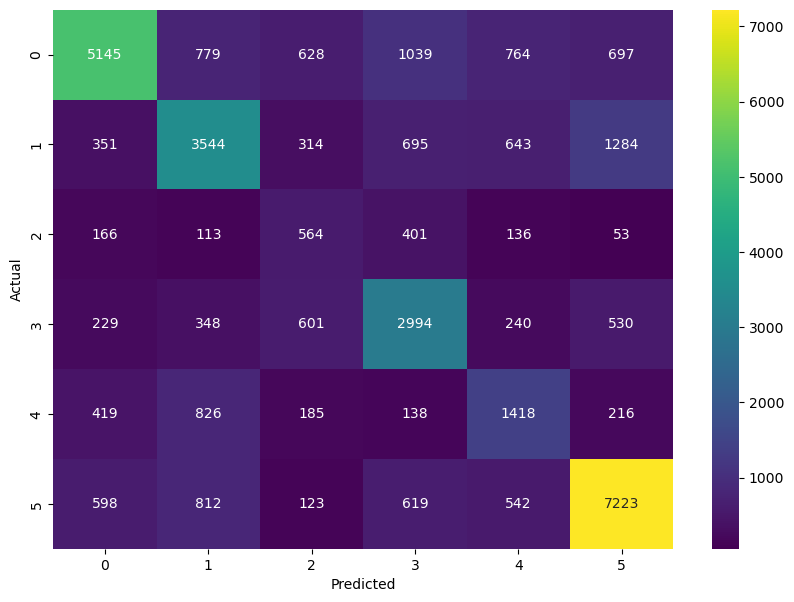

In [70]:
predicted_Y = value['model'].predict(test_X)
cm = confusion_matrix(y_test, predicted_Y)  # replace 'y_test' with your actual values
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Save the figure in high resolution
plt.savefig(f'confusion_matrix_4{DIS}{FET}.png', dpi=300)

plt.show()

In [71]:
results = metrics.classification_report(test_Y, predicted_Y)
results = results.split('\n')
results

['              precision    recall  f1-score   support',
 '',
 '           0       0.74      0.57      0.64      9052',
 '           1       0.55      0.52      0.53      6831',
 '           2       0.23      0.39      0.29      1433',
 '           3       0.51      0.61      0.55      4942',
 '           4       0.38      0.44      0.41      3202',
 '           5       0.72      0.73      0.73      9917',
 '',
 '    accuracy                           0.59     35377',
 '   macro avg       0.52      0.54      0.53     35377',
 'weighted avg       0.61      0.59      0.60     35377',
 '']

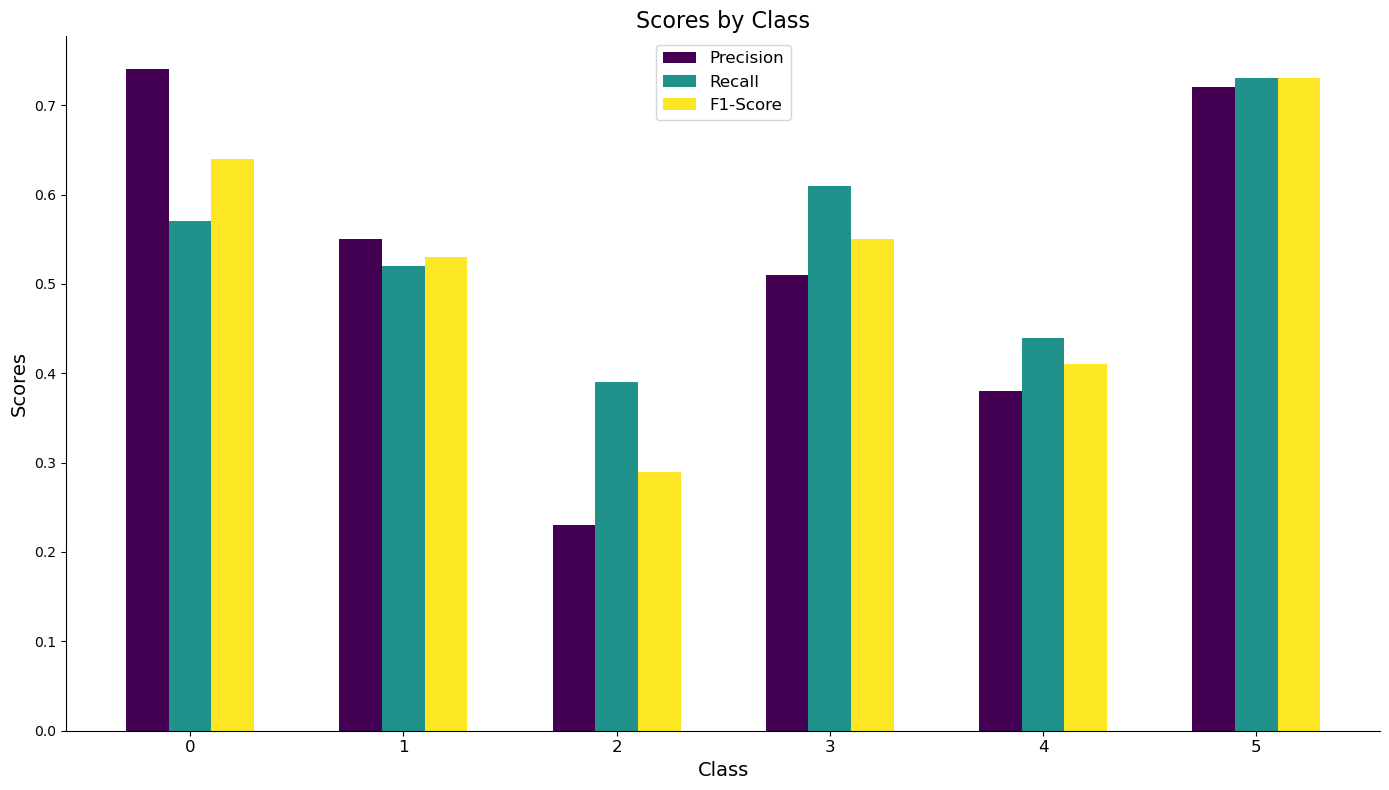

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Provided data
data = ['              precision    recall  f1-score   support',
 '',
 '           0       0.74      0.57      0.64      9052',
 '           1       0.55      0.52      0.53      6831',
 '           2       0.23      0.39      0.29      1433',
 '           3       0.51      0.61      0.55      4942',
 '           4       0.38      0.44      0.41      3202',
 '           5       0.72      0.73      0.73      9917',
 '',
 '    accuracy                           0.59     35377',
 '   macro avg       0.52      0.54      0.53     35377',
 'weighted avg       0.61      0.59      0.60     35377',
 '']

# Parse the data
labels = []
precision = []
recall = []
f1 = []
support = []

for line in data:
    parts = line.split()
    if len(parts) == 5 and parts[0].isdigit():
        labels.append(parts[0])
        precision.append(float(parts[1]))
        recall.append(float(parts[2]))
        f1.append(float(parts[3]))
        support.append(int(parts[4]))

# Colors from the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, 3))

# Plot
bar_width = 0.2
index = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(14, 8))
bar1 = ax.bar(index, precision, bar_width, label='Precision', color=colors[0])
bar2 = ax.bar(index + bar_width, recall, bar_width, label='Recall', color=colors[1])
bar3 = ax.bar(index + 2*bar_width, f1, bar_width, label='F1-Score', color=colors[2])

# Set axis labels, title, and legend
ax.set_xlabel('Class', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Scores by Class', fontsize=16)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(labels, fontsize=12)
ax.legend(fontsize=12)

# Enhancing aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


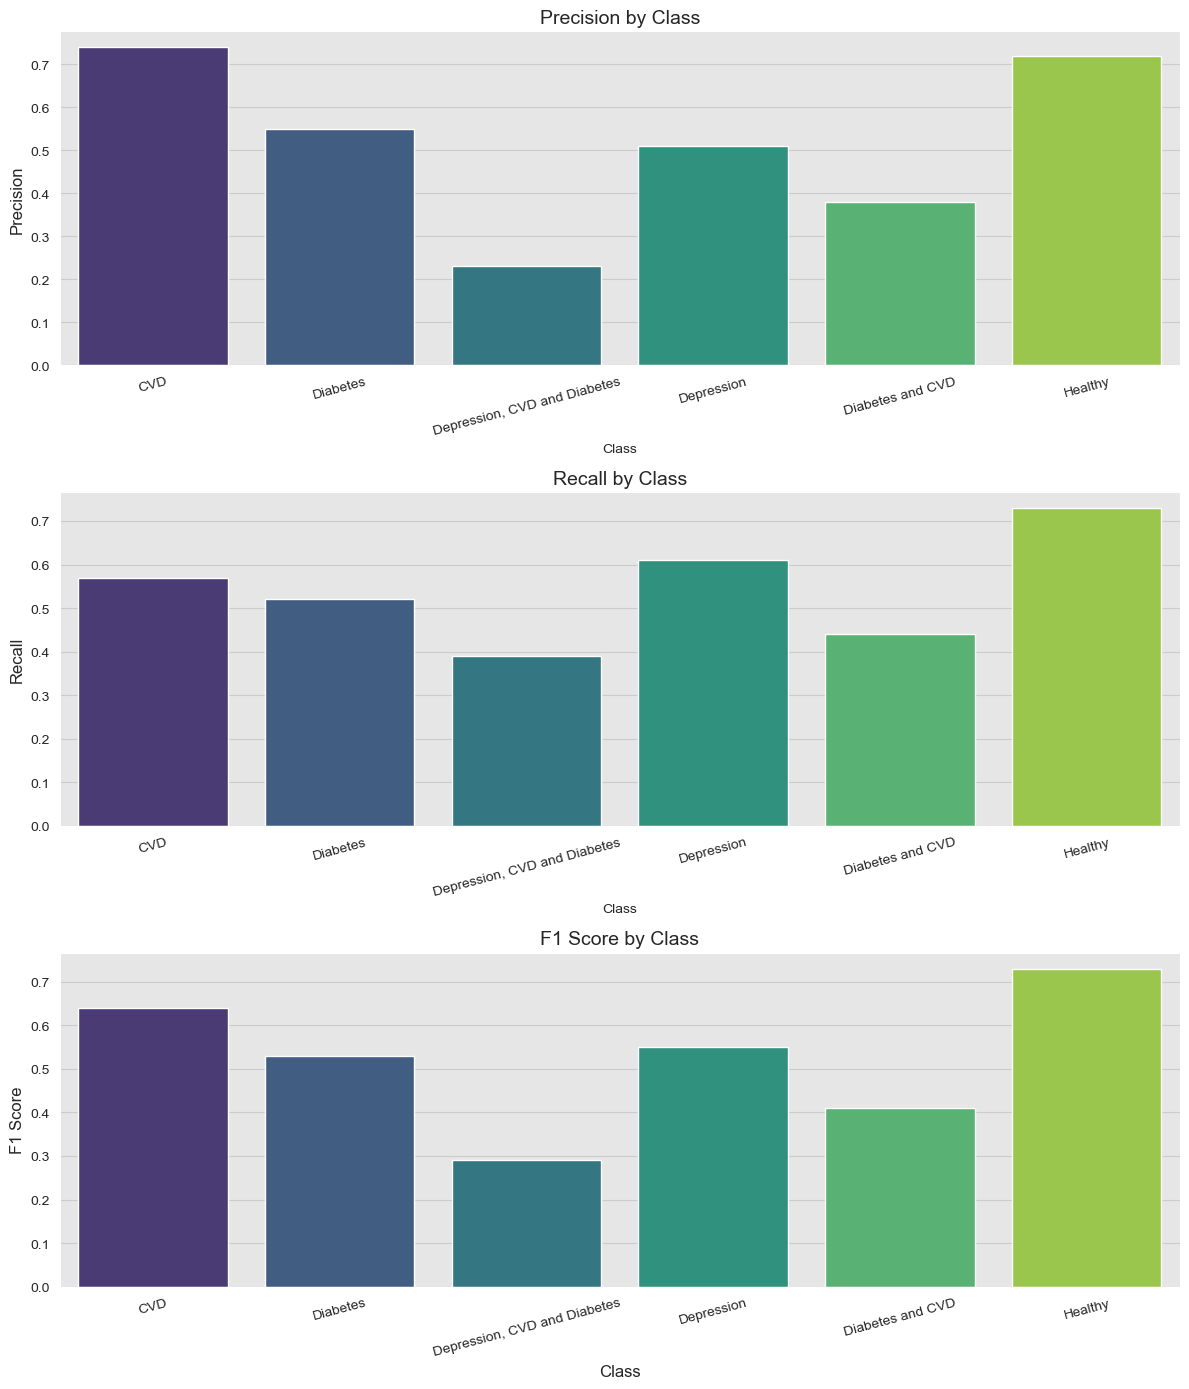

Plot saved as metrics_by_class.png
Data saved as metrics_by_class.csv


In [77]:
# Parsing the provided data
labels, precision, recall, f1, support = [], [], [], [], []
for line in data[2:8]:  # Skipping the header and other lines
    parts = line.split()
    labels.append(int(parts[0]))
    precision.append(float(parts[1]))
    recall.append(float(parts[2]))
    f1.append(float(parts[3]))
    support.append(int(parts[4]))

# Convert to DataFrame
df = pd.DataFrame({
    'Class': labels,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'Support': support
})

# Map class numbers to names
class_names = {
    0: 'CVD',
    1: 'Diabetes',
    2: 'Depression, CVD and Diabetes',
    3: 'Depression',
    4: 'Diabetes and CVD',
    5: 'Healthy'
}
df['Class'] = df['Class'].replace(class_names)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# Set a dark grid style
sns.set_style("darkgrid", {
    "axes.facecolor": ".9",
    "grid.color": ".8"
})
sns.set_palette("viridis", 3)

# Precision subplot
sns.barplot(x='Class', y='Precision', data=df, ax=axes[0], palette='viridis')
axes[0].set_title('Precision by Class', fontsize=14)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)

# Recall subplot
sns.barplot(x='Class', y='Recall', data=df, ax=axes[1], palette='viridis')
axes[1].set_title('Recall by Class', fontsize=14)
axes[1].set_ylabel('Recall', fontsize=12)
axes[1].tick_params(axis='x', rotation=15)

# F1-score subplot
sns.barplot(x='Class', y='F1', data=df, ax=axes[2], palette='viridis')
axes[2].set_title('F1 Score by Class', fontsize=14)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_xlabel('Class', fontsize=12)
axes[2].tick_params(axis='x', rotation=15)

# Adjust layout
plt.tight_layout()

# Save the plot to an image file
plot_filename = "metrics_by_class.png"
plt.savefig(plot_filename, dpi=300)

# Save the DataFrame to a CSV file
csv_filename = "metrics_by_class.csv"
df.to_csv(csv_filename, index=False)

plt.show()

print(f"Plot saved as {plot_filename}")
print(f"Data saved as {csv_filename}")

In [78]:
value['model']

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('RUS', RandomUnderSampler(random_state=28)),
                ('select_features',
                 SelectFromModel(estimator=XGBClassifier(base_score=None,
                                                         booster=None,
                                                         callbacks=None,
                                                         colsample_bylevel=None,
                                                         colsample_bynode=None,
                                                         colsample_bytree=None,
                                                         early_stopping_rounds=None,
                                                         enable_categorical=False,
                                                         eval_metric=None,
                                                         feature...
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.2271281815592922, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=2,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [79]:
import shap
from sklearn.compose import ColumnTransformer

In [80]:
print(value['model'].named_steps)

{'impute': SimpleImputer(strategy='median'), 'RUS': RandomUnderSampler(random_state=28), 'select_features': SelectFromModel(estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=None, gpu_id=None,
                                        grow_policy=None, importance_type=None,
                                        interaction_constraints=None,
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to

In [82]:
# Step 1: Extract the final RandomForest classifier from the pipeline
xgb_model = value['model'].named_steps['XGB']  # Assuming this is the name of the step in the pipeline

In [83]:
# 1. Imputation
transformed_data = value['model'].named_steps['impute'].transform(testData)

# 2. Random Under Sampling
transformed_data, transformed_y = value['model'].named_steps['RUS'].fit_resample(transformed_data, y_test)

# 3. Feature selection
transformed_data = value['model'].named_steps['select_features'].fit_transform(transformed_data, transformed_y)

`use_label_encoder` is deprecated in 1.7.0.


In [84]:
transformed_data_df = pd.DataFrame(transformed_data, columns=list(testData.columns[value['features']]))

In [86]:
# Create the explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer.shap_values(transformed_data_df)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [87]:
y_test

eid
1132237    0
4375677    0
1801277    3
4582480    1
2249476    3
          ..
5112739    5
4663281    5
2773868    5
2419236    4
1535849    1
Name: Cluster, Length: 35377, dtype: int64

In [91]:
# For a single instance (e.g., the first one)
shap.force_plot(explainer.expected_value[3], shap_values[1][0], transformed_data_df.iloc[2:3]) # 2 

In [92]:
import matplotlib.colors as mcolors

In [93]:
# Create a colormap that maps from SHAP values to magma colors
max_val = np.abs(shap_values).max()
colors = plt.get_cmap('viridis')  # Change from 'viridis' to 'magma'
shap_colors = [colors(i) for i in np.linspace(0, 1, 256)]
cmap = mcolors.LinearSegmentedColormap.from_list("shap_viridis", shap_colors)  # Rename to "shap_magma"

In [ ]:
# Plot 2
# Map class numbers to names
class_names = {
    0: 'CVD',
    1: 'Diabetes',
    2: 'Depression, CVD and Diabetes',
    3: 'Depression',
    4: 'Diabetes and CVD',
    5: 'Healthy'
}

In [86]:
# Generate the first plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')
shap.summary_plot(shap_values[1], transformed_data_df, cmap=cmap, show=False)
order_1 = [tick.get_text() for tick in plt.gca().get_yticklabels()]
plt.close()

The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


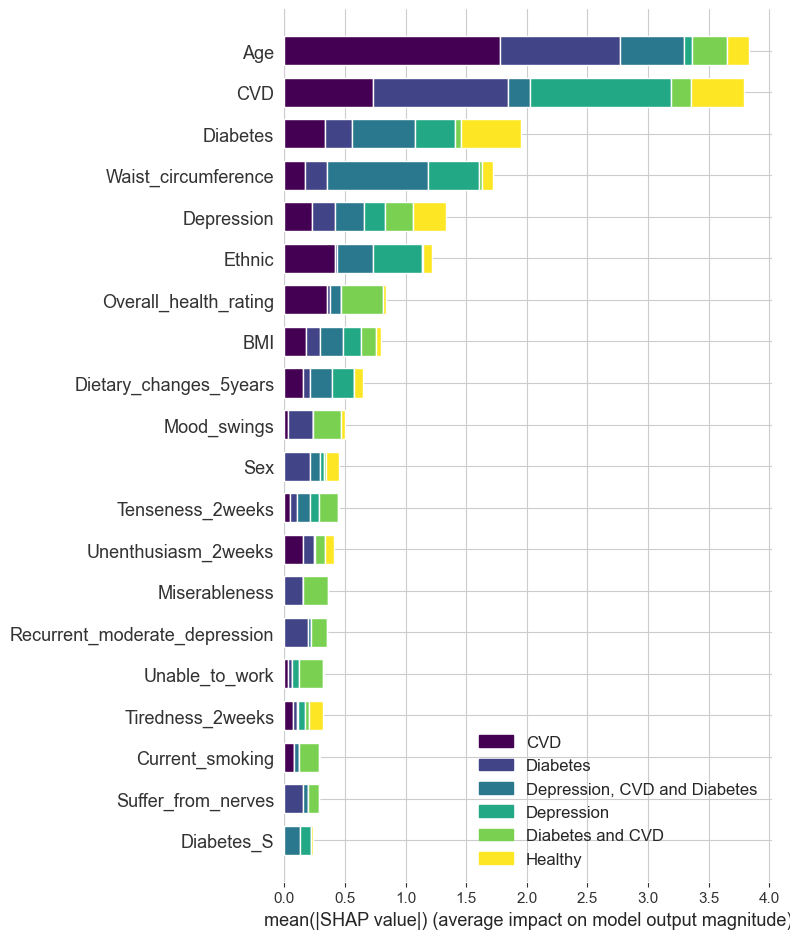

In [104]:
# Determine the ordering of features based on importance
overall_importance = np.sum(np.abs(shap_values[1]), axis=0)
sorted_indices = np.argsort(overall_importance)[::-1]
sorted_transformed_data_df = transformed_data_df.iloc[:, sorted_indices]
sorted_shap_values = [s[:, sorted_indices] for s in shap_values]

# Create a new colormap by repeating the viridis colors 6 times
viridis = plt.get_cmap('viridis')
colors = viridis(np.linspace(0, 1, 6))
new_colors = np.vstack([colors] * 6)
new_cmap = mcolors.ListedColormap(new_colors)

shap.summary_plot(sorted_shap_values, sorted_transformed_data_df, show=False, color=new_cmap)

# Set background color to white
ax = plt.gca()
ax.set_facecolor('white')

# Modify the legend to match the viridis colors
legend = ax.legend_
if legend:
    for idx, (text, handle) in enumerate(zip(legend.get_texts(), legend.legendHandles)):
        class_idx = idx % 6
        text.set_text(list(class_names.values())[class_idx])
        handle.set_edgecolor(colors[class_idx])
        handle.set_facecolor(colors[class_idx])

fig = plt.gcf()
fig.tight_layout()
file_name = f"summary_features_II{DIS}{FET}.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')
plt.show()

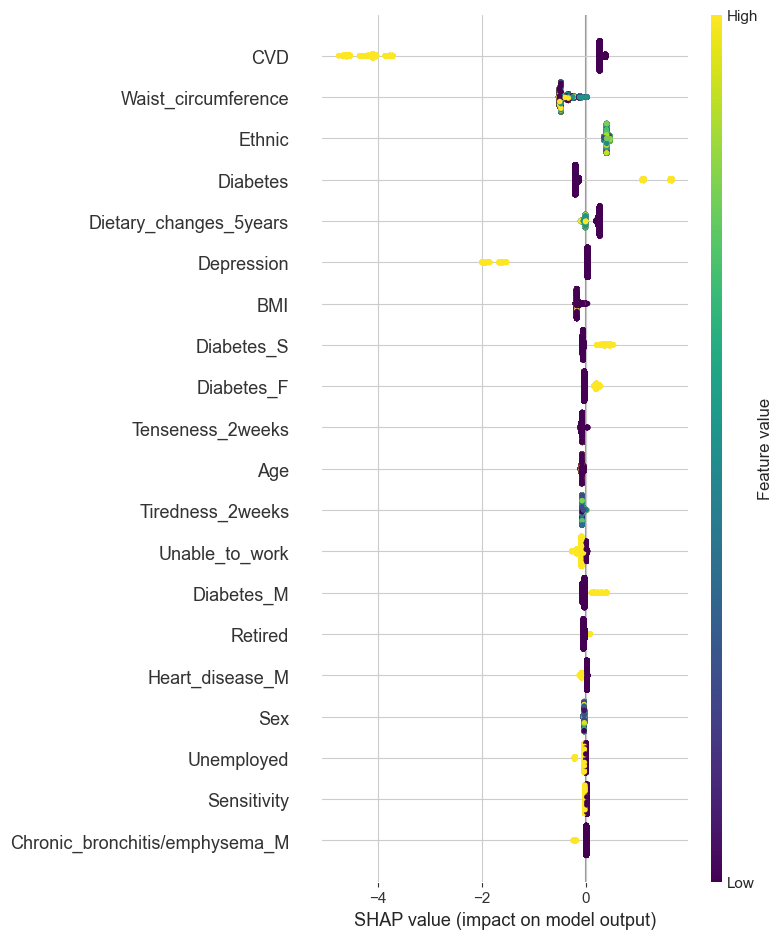

In [105]:
# Assuming you've already computed the sorted_indices from the previous code

# Sort the single-class SHAP values and the dataset using the order
sorted_shap_values_1 = shap_values[1][:, sorted_indices]
sorted_transformed_data_df_1 = transformed_data_df.iloc[:, sorted_indices]

# Plot 1
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('white')

shap.summary_plot(sorted_shap_values_1, sorted_transformed_data_df_1, cmap=cmap)

fig.tight_layout()
file_name = f"summary_plot_II{DIS}{FET}.png"
fig.savefig(file_name, dpi=300, bbox_inches='tight')
plt.show()